In [0]:
import pandas as pd
import numpy as np
#import pydicom
import glob
import os
import pandas as pd
import numpy as np
#import pydicom
#import glob
#import os
import re
from pathlib import Path
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
#import re
#from pathlib import Path

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout,Input,Average,Conv2DTranspose,SeparableConv2D,dot,UpSampling2D,Add, Flatten,Concatenate,Multiply,Conv2D, MaxPooling2D,Activation,AveragePooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint 

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50,VGG19,VGG16,DenseNet121,DenseNet169,InceptionResNetV2

import numpy as np
from skimage.morphology import square,binary_erosion,binary_dilation,binary_opening,binary_closing
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from keras.initializers import RandomNormal
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras import regularizers
from keras.models import Model

Using TensorFlow backend.


In [0]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive',force_remount=True)
root_dir='/content/gdrive/My Drive/'
base_dir=root_dir+'Colab Notebooks/'

Mounted at /content/gdrive


In [0]:
import tensorflow as tf


In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:

Y=np.load(root_dir+'DATASET/Yall.npy')
Y.shape


(5697, 320, 320, 5)

In [8]:

X=np.load(root_dir+'DATASET/X_2D.npy')
X.shape


(5862, 512, 512)

In [0]:

def normalize(img):
    arr = img.copy().astype(np.float)
    M = np.float(np.max(img))
    if M != 0:
        arr *= 1./M
    return arr
    
def cropimread(crop, xcrop, ycrop):
    ysize = crop.shape[0]
    xsize = crop.shape[1]
    xoff = (xsize - xcrop) // 2
    yoff = (ysize - ycrop) // 2
    crop= crop[yoff:-yoff,xoff:-xoff]
    return crop

In [0]:
Ximg = []
from skimage.transform import resize
for i in range(X.shape[0]):
    HH = cropimread(X[i,:,:], 320,320)
    HH = normalize(HH)
    #HH = resize(HH, (320, 320))
    Ximg.append(HH)

X = []
Ximg = np.asarray(Ximg)


In [0]:
Ximg = np.delete(Ximg,np.s_[141:306],axis=0)

In [12]:
Ximg.shape

(5697, 320, 320)

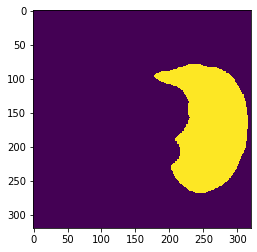

In [17]:
plt.imshow(Y[200,:,:,1])

In [0]:
Yimg = Y
Y = []

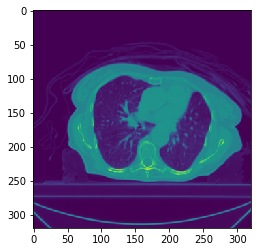

In [22]:
plt.imshow(Ximg[72,:,:])

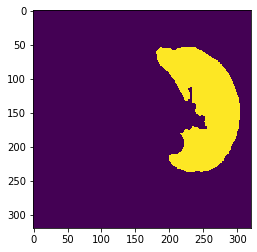

In [23]:
plt.imshow(Yimg[72,:,:,1])

In [24]:
Ximg[72,:,:]

array([[-0.97360704, -0.97556207, -0.97556207, ..., -0.97360704,
        -0.97556207, -0.97653959],
       [-0.97458456, -0.97458456, -0.97458456, ..., -0.97556207,
        -0.97360704, -0.97360704],
       [-0.97458456, -0.97360704, -0.97360704, ..., -0.97653959,
        -0.97458456, -0.97360704],
       ...,
       [-0.97067449, -0.96969697, -0.96969697, ..., -0.971652  ,
        -0.97556207, -0.97458456],
       [-0.97262952, -0.96969697, -0.96969697, ..., -0.97360704,
        -0.97360704, -0.97556207],
       [-0.97360704, -0.971652  , -0.97067449, ..., -0.971652  ,
        -0.97262952, -0.97360704]])

In [25]:
Yimg.shape

(5697, 320, 320, 5)

In [0]:
Ximg = Ximg[:,:,:,None]


X_train, X_test, y_train, y_test = train_test_split(Ximg, Yimg, random_state=42, test_size=0.2)
# def dataloader(x,y,bs):
#     indices = np.arange(x.shape[0])
#     np.random.shuffle(indices)
    
#     for i in range(0,len(indices),bs):
#         yield x[i:i+bs] , y[i:i+bs]
    

In [27]:
Ximg = []
Yimg = []
X_train.shape

# X_train = X_train[:,:,:,None]
# y_train = y_train[:,:,:,None]

# X_test = X_test[:,:,:,None]
# y_test = y_test[:,:,:,None]

(4557, 320, 320, 1)

In [0]:


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return K.sum(score)

def weighted_dice_loss(y_true, y_pred):
    smooth = 1.
    w, m1, m2 = 0.7, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)


# def atrous_spatial_pyramid_pooling(net, depth=256, reuse=None):
#     # apply global average pooling
#     image_level_features = GlobalAveragePooling2D()(net)
#     image_level_features = Conv2D(depth, (1, 1), scope="image_level_conv_1x1")(image_level_features)
#     image_level_features = tf.image.resize_bilinear(image_level_features, (feature_map_size[1], feature_map_size[2]))
    
#     at_pool1x1 = Conv2D(net, depth, (1, 1), scope="conv_1x1_0")(net)

#     at_pool3x3_1 = Conv2D(net, depth, (3, 3), scope="conv_3x3_1", rate=6)(net)

#     at_pool3x3_2 = Conv2D(net, depth, (3, 3), scope="conv_3x3_2", rate=12)(net)

#     at_pool3x3_3 = Conv2D(depth, (3, 3), scope="conv_3x3_3", rate=18)(net)

#     net = concatenate((image_level_features, at_pool1x1, at_pool3x3_1, at_pool3x3_2, at_pool3x3_3), axis=3,
#                         name="concat")
#     net = Conv2D(depth, (1, 1), scope="conv_1x1_output")(net)
#     return net



In [0]:
# def conv_2d(input_layer,n_filters,kernel,padding='same',strides=(1,1)):
#     layer=Conv2D(n_filters,kernel,padding=padding,strides=strides,W_regularizer=l2(0.0004))(input_layer)
#     layer=BatchNormalization(axis=-1,momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(layer)
#     return LeakyReLU(alpha=0.1)(layer)

In [0]:
def Attention_B(X, G, k):
    FL = int(X.shape[-1])
    init = RandomNormal(stddev=0.02)
    theta = Conv2D(k,(2,2), strides = (2,2), padding='same')(X)
    Phi = Conv2D(k, (1,1), strides =(1,1), padding='same', use_bias=True)(G)
    
    ADD = Add()([theta, Phi])
    
    #ADD = LeakyReLU(alpha=0.1)(ADD)
    ADD = Activation('relu')(ADD)
    
    #Psi = Conv2D(FL,(1,1), strides = (1,1), padding="same",kernel_initializer=init)(ADD)
    Psi = Conv2D(1,(1,1), strides = (1,1), padding="same",kernel_initializer=init)(ADD)
    Psi = Activation('sigmoid')(Psi)
    Up = Conv2DTranspose(1, (2,2), strides=(2, 2), padding='valid')(Psi)
    
    #Psi = Activation('tanh')(Psi)
    
    #Up = Conv2DTranspose(FL, (2,2), strides=(2, 2), padding='valid')(Psi)
    
    Final = Multiply()([X, Up])
    Final = Conv2D(1, (1,1), strides = (1,1), padding="same",kernel_initializer=init)(Final)
    #Final = Conv2D(FL, (1,1), strides = (1,1), padding="same",kernel_initializer=init)(Final)
    Final = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-5)(Final)
    print(Final.shape)
    return Final


In [0]:
def Unet3(input_shape,n_filters,kernel=(3,3),strides=(1,1),pad='same'):
    x = input_shape
    conv1 = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(input_shape)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    
    conv2 = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(conv1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 =  LeakyReLU(alpha=0.1)(conv2)
    
    x = Conv2D(n_filters,kernel_size = (1,1),strides = (1,1),padding = 'same')(x)
    
    return Add()([x,conv2])
    


In [0]:
def Up3(input1,input2,kernel=(3,3),stride=(1,1), pad='same'):
    #up = UpSampling2D(2)(input2)
    up = Conv2DTranspose(int(input1.shape[-1]),(1, 1), strides=(2, 2), padding='same')(input2)
    #assert up.shape == input1.shape
    up = Concatenate()([up,input1])
    
    return Unet3(up,int(input1.shape[-1]),kernel,stride,pad)
  

In [0]:



def gatingSig(input_shape,n_filters,kernel=(1,1),strides=(1,1),pad='same'):
    conv = Conv2D(n_filters,kernel_size=kernel,strides=strides,padding=pad)(input_shape)
    conv = BatchNormalization(axis=-1)(conv)
    return LeakyReLU(alpha=0.1)(conv)

def DSup(x, var):
    d = Conv2D(1,(1,1), strides=(1,1), padding = "same")(x)
    d = UpSampling2D(var)(d)
    return d

def DSup1(x, var):
    d = Conv2D(1,(2,2), strides=(2,2), padding = "same")(x)
    d = UpSampling2D(var)(d)
    return d

In [0]:
def Inception(Image):
    n_labels=5
    feature_scale=8
    #input_shape= Image.shape
    filters = [64, 128, 256, 512,1024]

    #filters = [int(x /feature_scale) for x in filters]
        
    inputs = Input(Image)
    conv1 = Unet3(inputs,filters[0])
    maxp1 = MaxPooling2D(2)(conv1)
    
    
    conv2 = Unet3(maxp1,filters[1])
    maxp2 = MaxPooling2D(2)(conv2)
          
      
    conv3 = Unet3(maxp2,filters[2])
    maxp3 = MaxPooling2D(2)(conv3)
        
    conv4 = Unet3(maxp3,filters[3])
    maxp4 = MaxPooling2D(2)(conv4)
        
    center = Unet3(maxp4,filters[4])
    gating = gatingSig(center,filters[4])
        
    D1 = Attention_B(conv4,gating,filters[3])
    D2 = Up3(D1,gating)
        
    D3 = Attention_B(conv3,D2,filters[2])
    D4 = Up3(D3,D2)
    
            
    D5 = Attention_B(conv2,D4,filters[1])
    D6 = Up3(D5,D4)
        
    D7 = Up3(conv1, D6)
        
    DS1 = Conv2D(n_labels,(1,1), strides=(1,1), padding="same",activation='sigmoid')(D7)
        
        
    #DS4 = DSup1(D4,8)
    
    #DS4 = Conv2D(1,(2,2), strides=(2,2), padding="same")(DS4)
        
    #DDD = Concatenate()([DS1, DS4])
        
        
    #DDD = Conv2D(1,(1,1),strides=(1,1),padding="same")(DDD)
        
    model = Model(inputs, DS1)
    return model

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [35]:
X_train.shape

(4557, 320, 320, 1)

In [36]:
from keras.regularizers import l2
from keras import backend as K

G = Inception(X_train[0].shape)














(?, 40, 40, 1)
(?, 80, 80, 1)
(?, 160, 160, 1)


In [37]:
G.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 320, 320, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [38]:

import tensorflow as tf
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    d1 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    d2 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    
    y_true_f = K.flatten(y_true[:,:,:,2])
    y_pred_f = K.flatten(y_pred[:,:,:,2])
    intersection = K.sum(y_true_f * y_pred_f)
    d3 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    
    y_true_f = K.flatten(y_true[:,:,:,3])
    y_pred_f = K.flatten(y_pred[:,:,:,3])
    intersection = K.sum(y_true_f * y_pred_f)
    d4 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
    y_true_f = K.flatten(y_true[:,:,:,4])
    y_pred_f = K.flatten(y_pred[:,:,:,4])
    intersection = K.sum(y_true_f * y_pred_f)
    d5 =  (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return (d1+d2+d3+d4+d5)/5


    

def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

#opt = Adam(lr=1e-2)
G.compile(loss= dice_coefficient_loss, optimizer="adam", metrics=["accuracy","binary_crossentropy",dice_coefficient])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import math

(1140, 320, 320, 5)

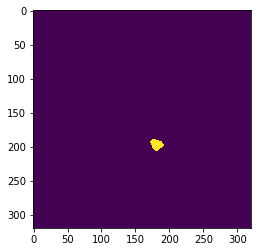

In [70]:
plt.imshow(y_train[1930,:,:,4])

In [0]:
weight_saver = ModelCheckpoint(root_dir+'DATASET/Lung_multi.h5', monitor = 'val_dice_coefficient', save_best_only = True, save_weights_only =True )

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return (0.001 *math.exp(0.1 * (10 - epoch)))

callback = keras.callbacks.LearningRateScheduler(scheduler)


class TrainingPlot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Before plotting ensure at least 2 epochs have passed
        if epoch >=0:
            
            # Clear the previous plot
            #clear_output(wait=True)
            img = y_test[73:75]
            img1 = y_train[1930:1932]
            
            gen_img = G.predict(X_test[73:75])
            gen_img1 = G.predict(X_train[1930:1932])
            
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            #plt.figure()
            plt.imshow(img[0,:,:,0],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,0] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img[0,:,:,1],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,1] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img[0,:,:,2],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,2] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img[0,:,:,3],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,3] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            
            plt.imshow(img[0,:,:,4],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img[0,:,:,4] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            
            plt.imshow(img1[0,:,:,0],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,0] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img1[0,:,:,1],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,1] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img1[0,:,:,2],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,2] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img1[0,:,:,3],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,3] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            plt.imshow(img1[0,:,:,4],cmap='gray',label = "Ground Truth")
            plt.pause(0.01)
            
            plt.imshow(gen_img1[0,:,:,4] ,cmap='gray', label = "predicted")
            plt.pause(0.01)
            
            
plots = TrainingPlot()


In [0]:
#G.load_weights(root_dir+'DATASET/Lung_multi.h5')

In [0]:
def train(x,y,models,bs, epochs = 3000):
    h = models.fit(x,y,batch_size = bs,epochs = epochs, callbacks = [weight_saver,plots],validation_data=(X_test, y_test))



Train on 4557 samples, validate on 1140 samples
Epoch 1/3000
4557/4557 [==============================] - 219s 48ms/step - loss: 0.6149 - acc: 0.0877 - binary_crossentropy: 0.6414 - dice_coefficient: 0.3851 - val_loss: 0.5823 - val_acc: 0.0574 - val_binary_crossentropy: 0.8302 - val_dice_coefficient: 0.4177


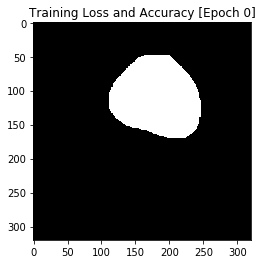

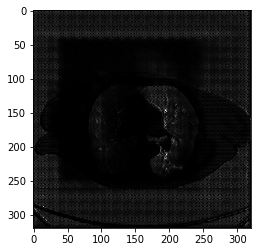

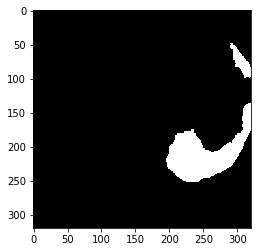

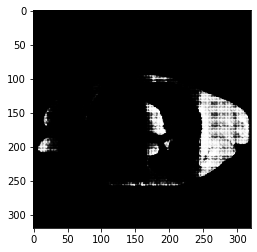

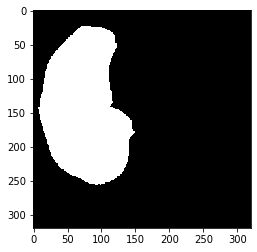

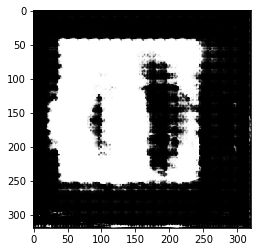

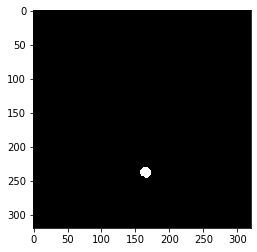

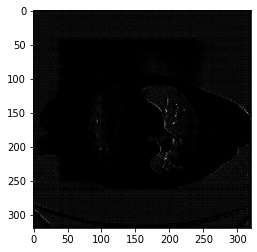

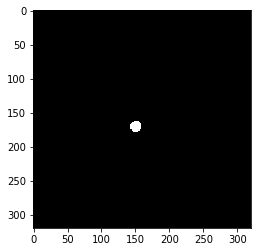

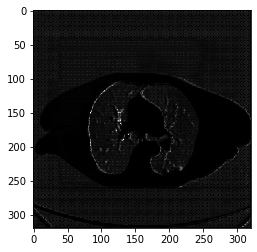

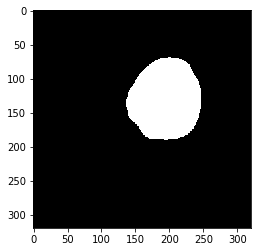

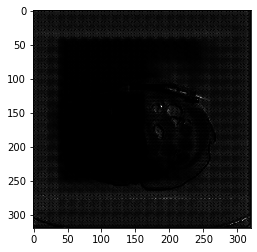

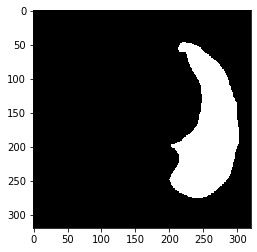

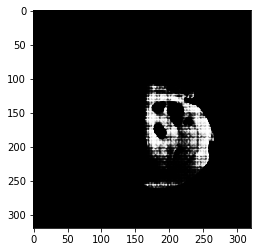

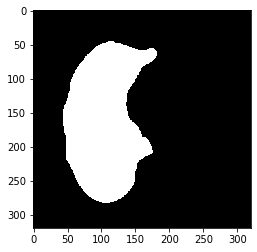

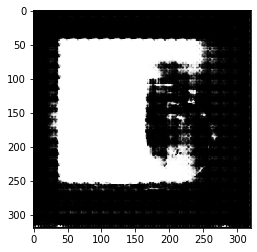

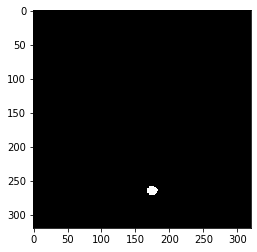

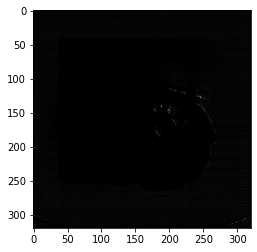

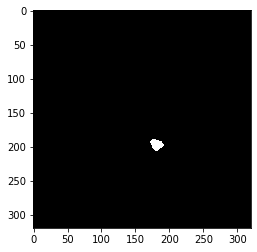

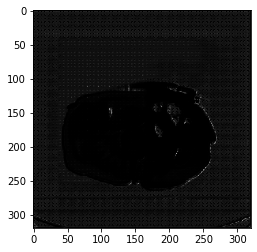

Epoch 2/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.4951 - acc: 0.0646 - binary_crossentropy: 0.4621 - dice_coefficient: 0.5049 - val_loss: 0.6731 - val_acc: 0.0529 - val_binary_crossentropy: 0.5653 - val_dice_coefficient: 0.3269


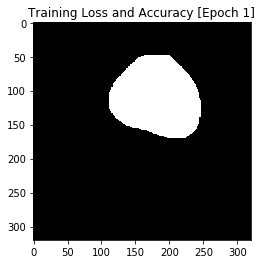

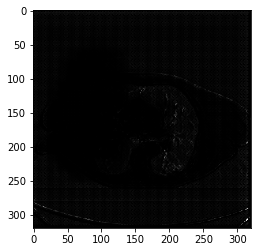

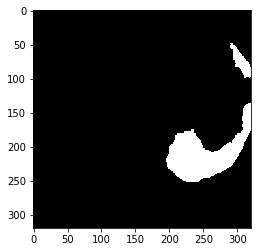

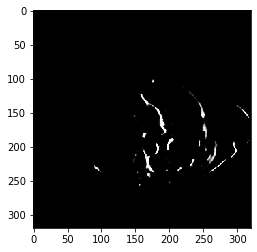

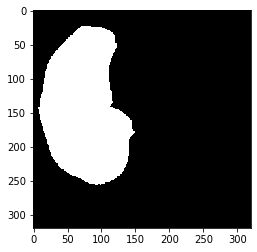

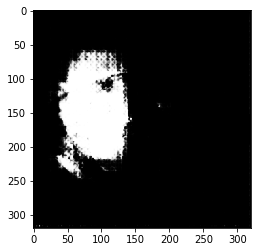

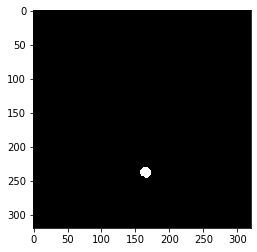

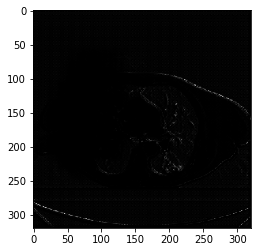

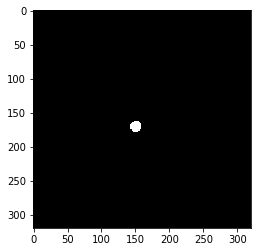

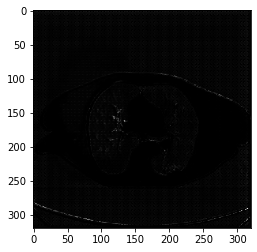

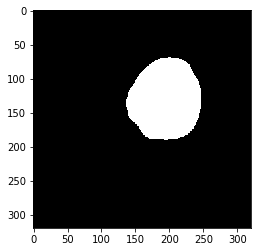

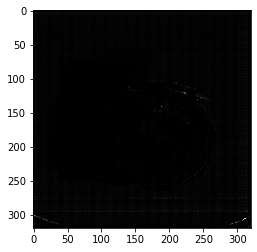

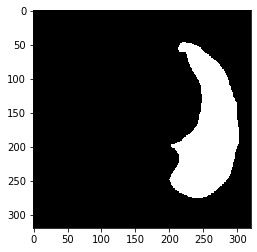

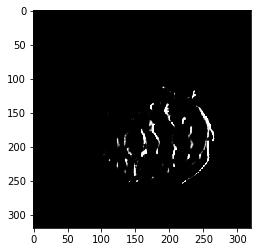

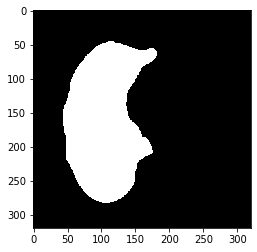

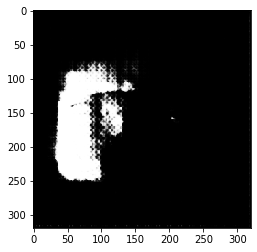

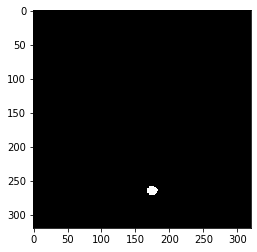

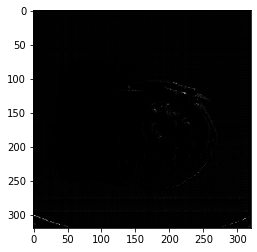

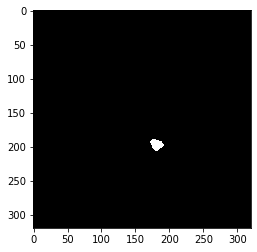

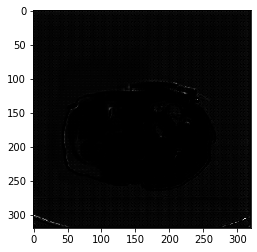

Epoch 3/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.4549 - acc: 0.0739 - binary_crossentropy: 0.4707 - dice_coefficient: 0.5451 - val_loss: 0.5770 - val_acc: 0.0500 - val_binary_crossentropy: 1.0776 - val_dice_coefficient: 0.4230


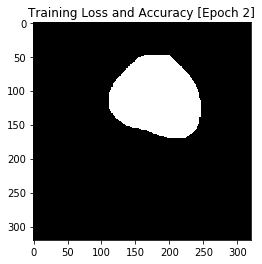

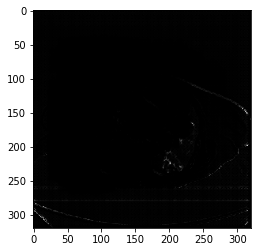

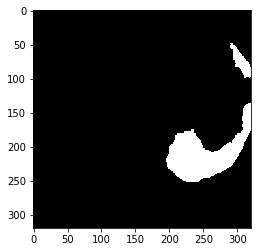

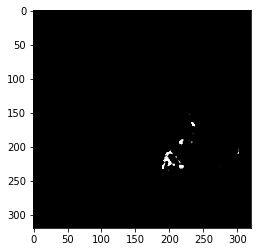

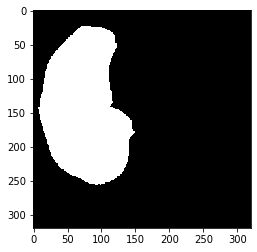

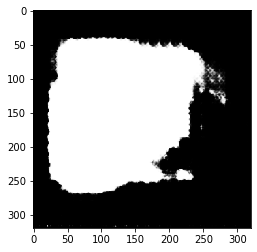

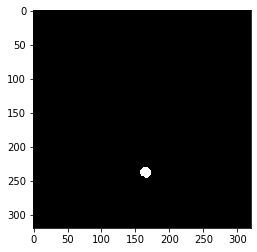

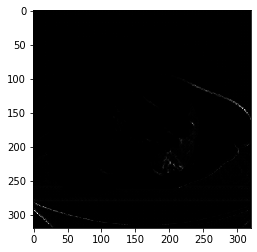

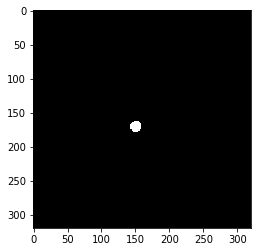

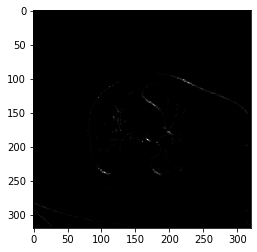

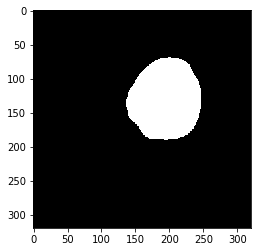

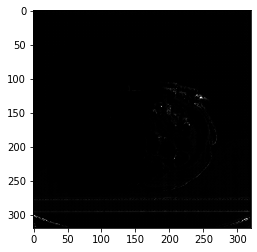

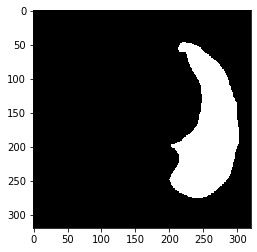

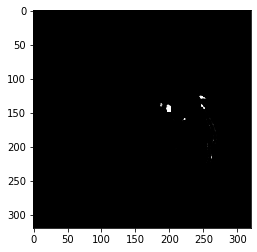

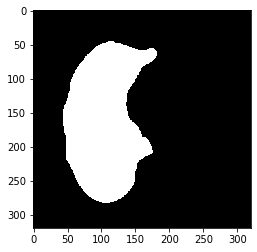

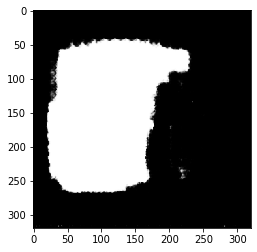

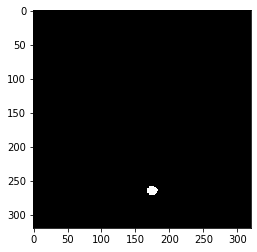

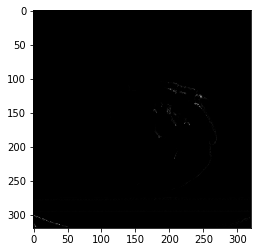

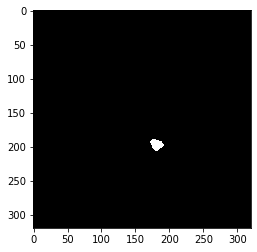

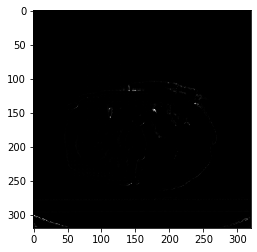

Epoch 4/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.4373 - acc: 0.0764 - binary_crossentropy: 0.4901 - dice_coefficient: 0.5627 - val_loss: 0.7008 - val_acc: 0.0654 - val_binary_crossentropy: 0.6371 - val_dice_coefficient: 0.2992


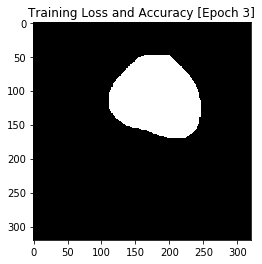

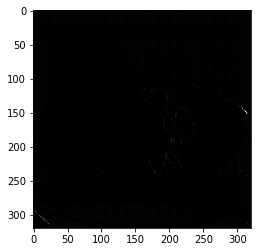

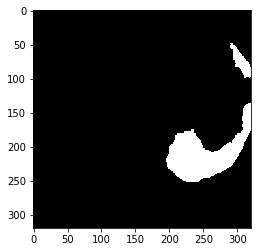

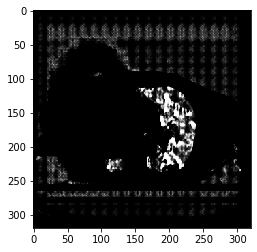

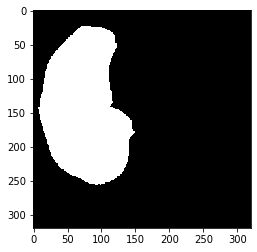

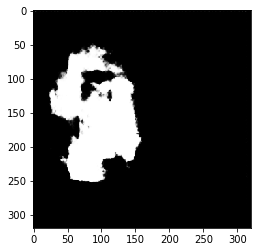

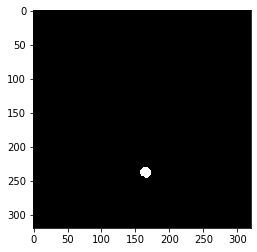

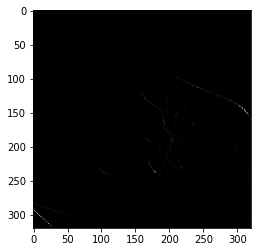

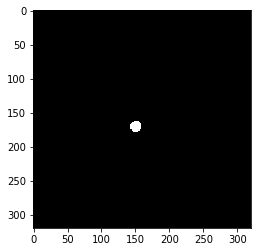

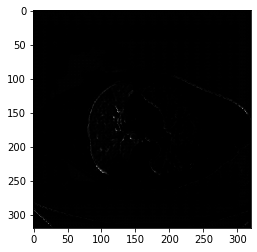

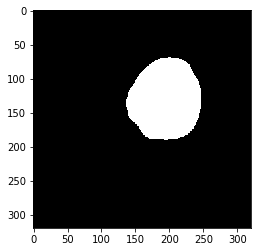

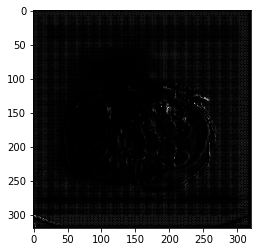

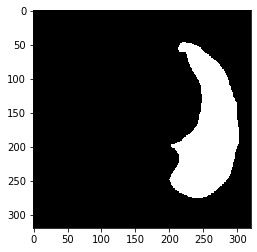

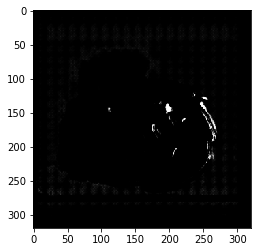

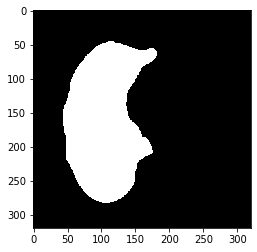

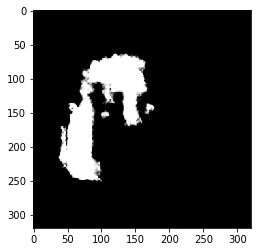

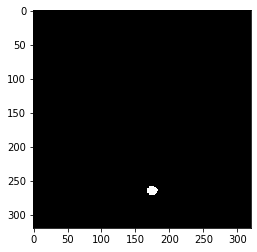

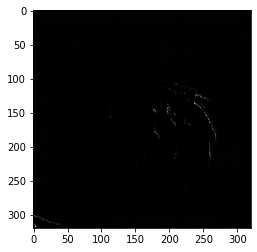

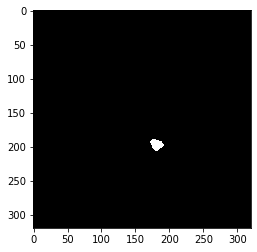

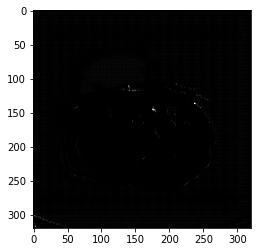

Epoch 5/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.4195 - acc: 0.1093 - binary_crossentropy: 0.4776 - dice_coefficient: 0.5805 - val_loss: 0.5081 - val_acc: 0.1059 - val_binary_crossentropy: 0.5393 - val_dice_coefficient: 0.4919


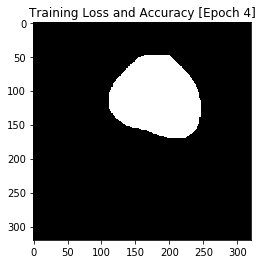

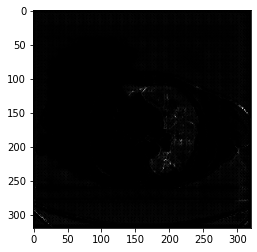

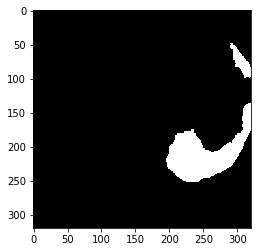

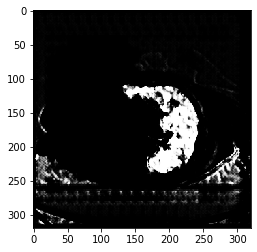

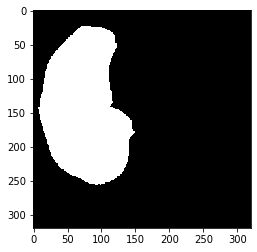

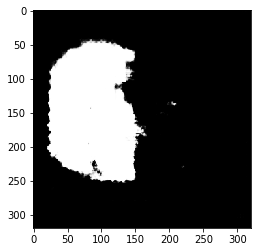

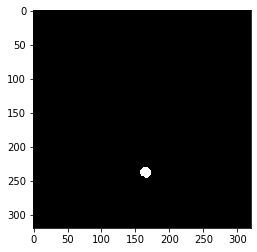

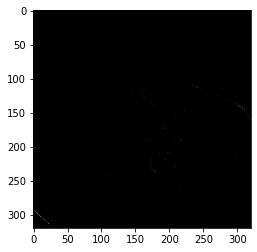

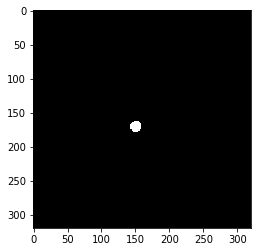

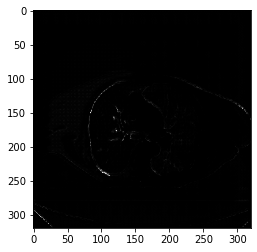

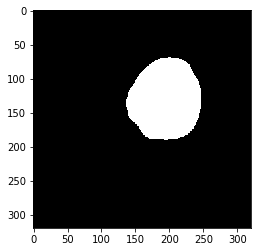

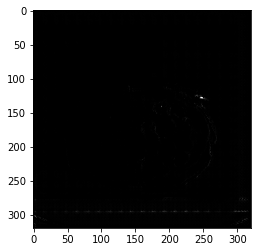

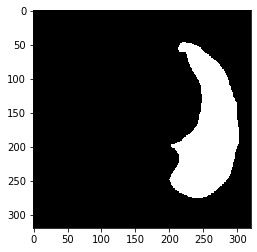

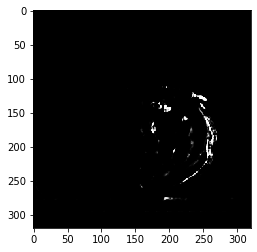

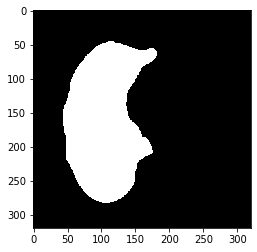

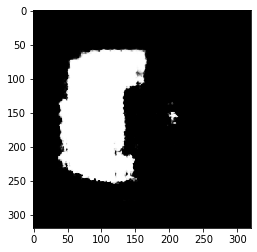

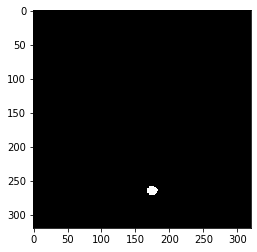

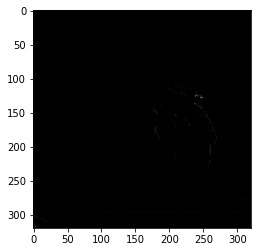

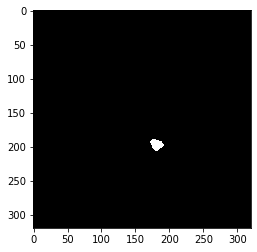

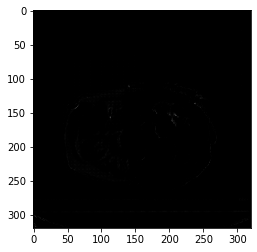

Epoch 6/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.3957 - acc: 0.1858 - binary_crossentropy: 0.4581 - dice_coefficient: 0.6043 - val_loss: 0.6545 - val_acc: 0.1183 - val_binary_crossentropy: 1.1483 - val_dice_coefficient: 0.3455


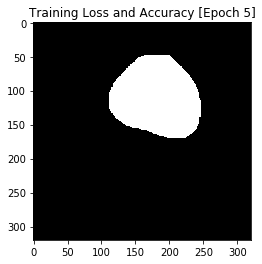

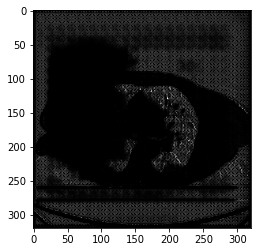

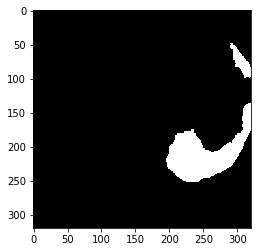

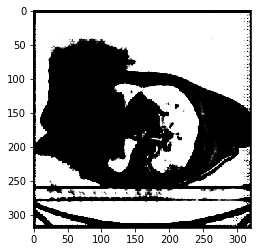

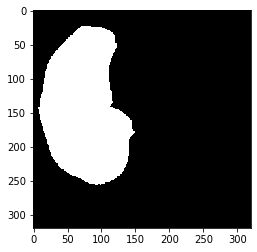

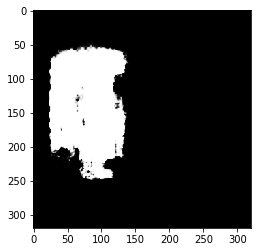

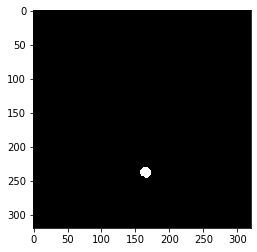

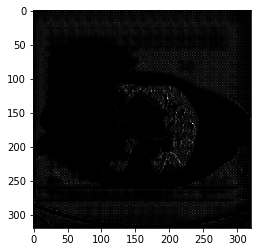

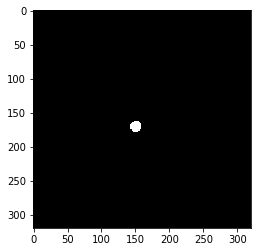

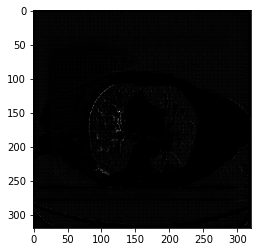

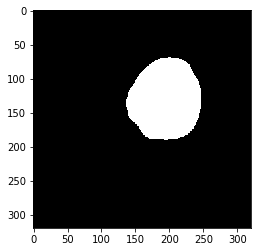

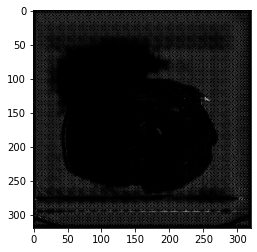

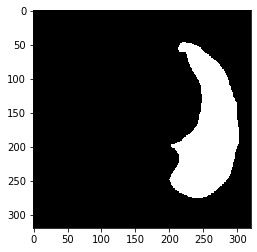

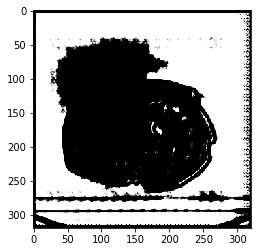

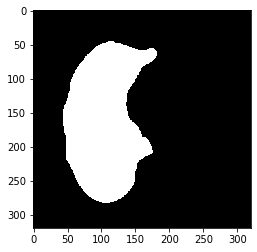

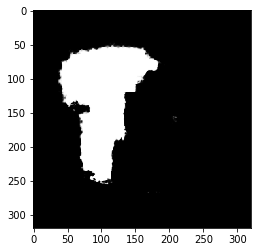

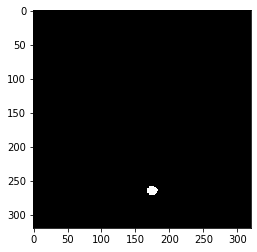

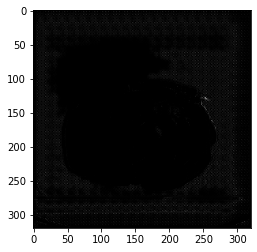

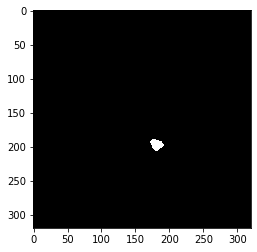

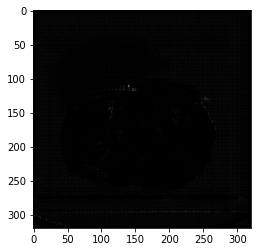

Epoch 7/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.3735 - acc: 0.2553 - binary_crossentropy: 0.4219 - dice_coefficient: 0.6265 - val_loss: 0.4682 - val_acc: 0.1982 - val_binary_crossentropy: 0.5641 - val_dice_coefficient: 0.5318


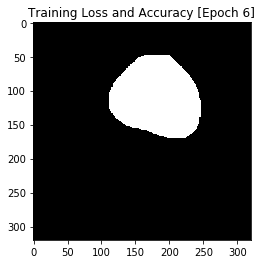

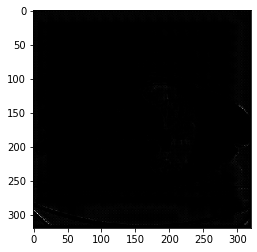

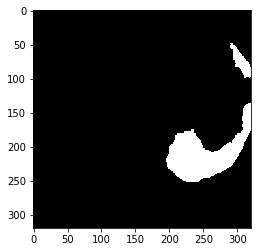

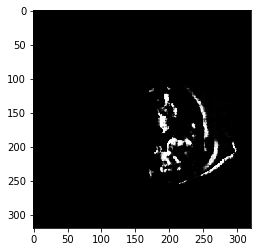

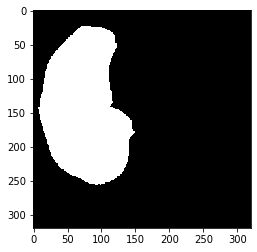

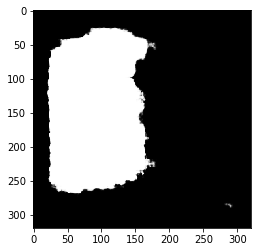

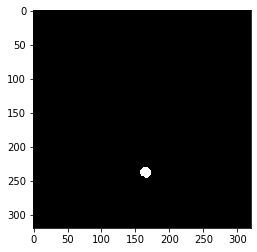

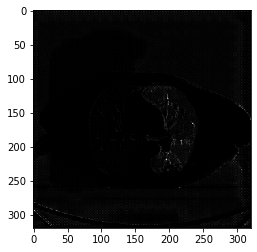

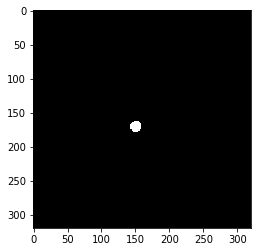

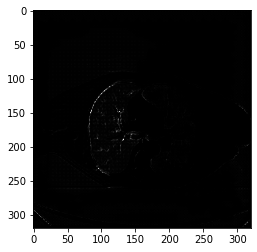

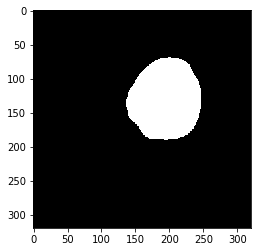

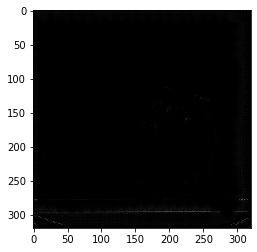

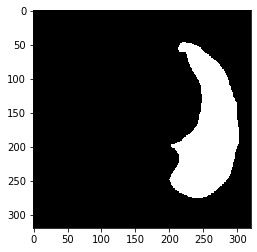

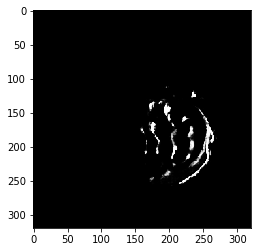

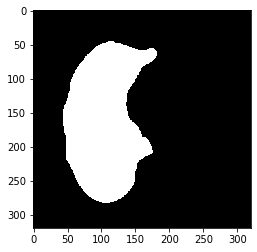

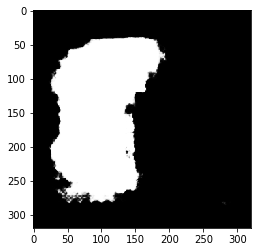

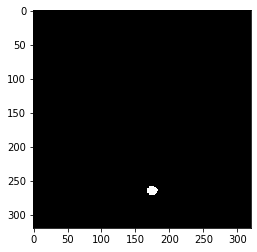

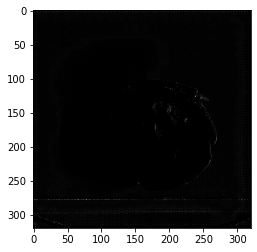

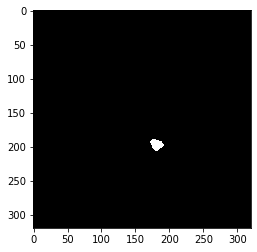

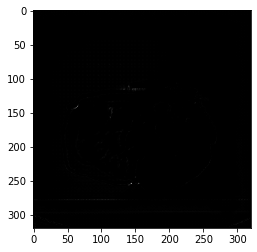

Epoch 8/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.3472 - acc: 0.2529 - binary_crossentropy: 0.3519 - dice_coefficient: 0.6528 - val_loss: 0.5356 - val_acc: 0.0829 - val_binary_crossentropy: 0.9258 - val_dice_coefficient: 0.4644


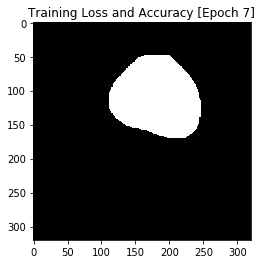

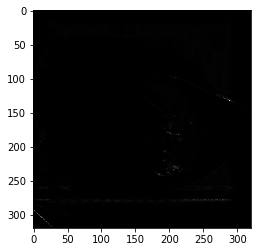

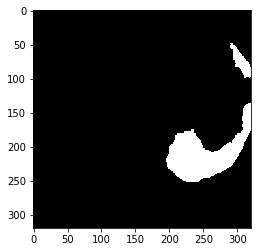

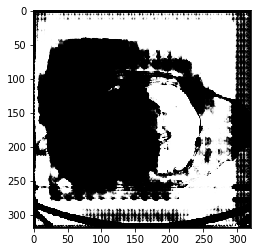

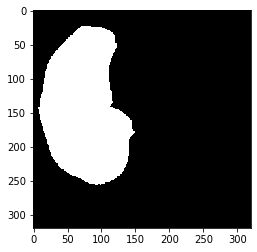

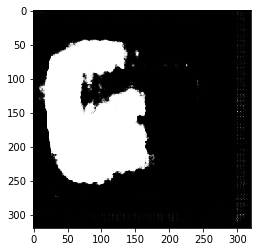

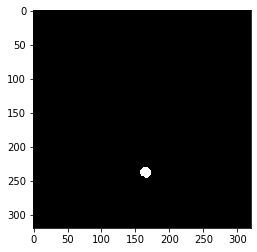

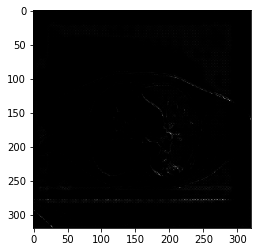

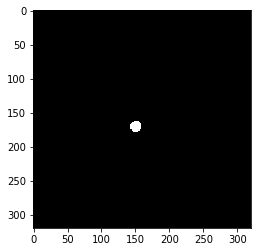

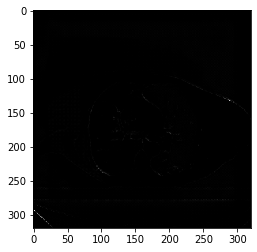

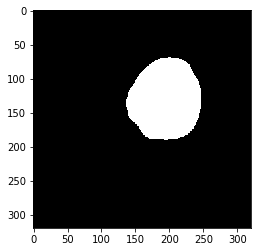

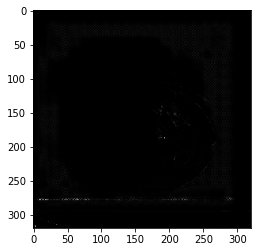

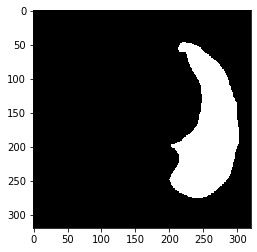

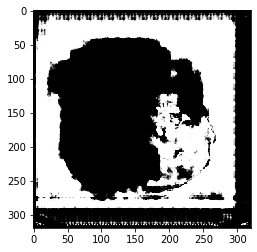

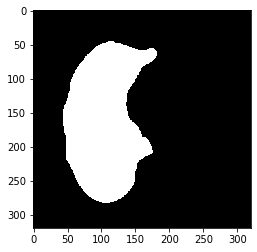

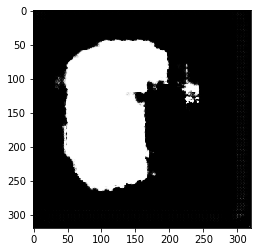

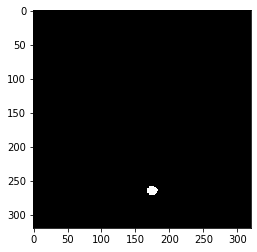

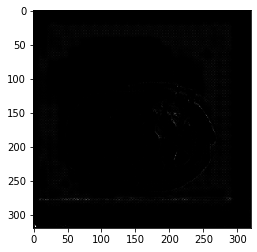

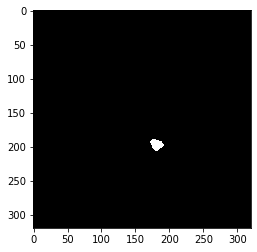

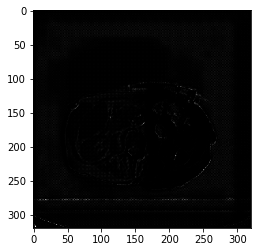

Epoch 9/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.2891 - acc: 0.2760 - binary_crossentropy: 0.2953 - dice_coefficient: 0.7109 - val_loss: 0.5140 - val_acc: 0.1490 - val_binary_crossentropy: 0.7473 - val_dice_coefficient: 0.4860


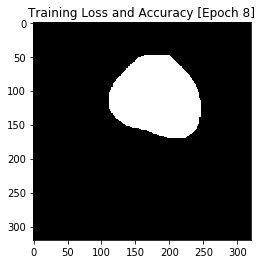

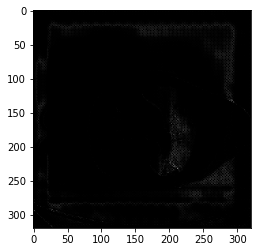

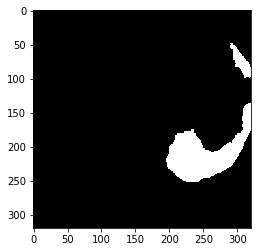

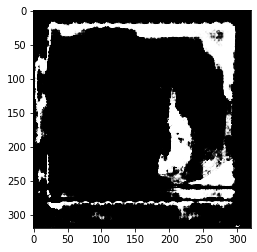

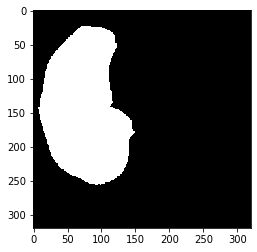

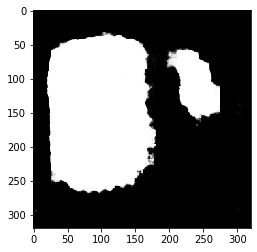

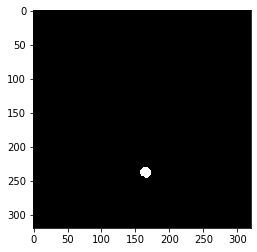

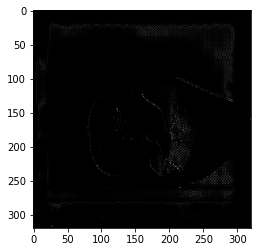

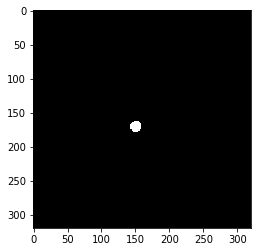

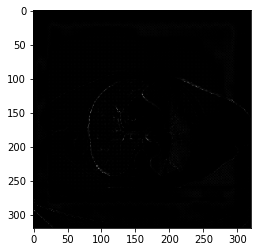

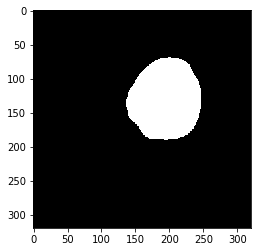

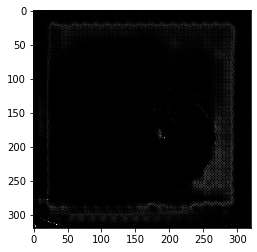

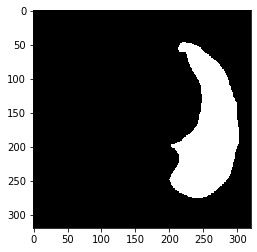

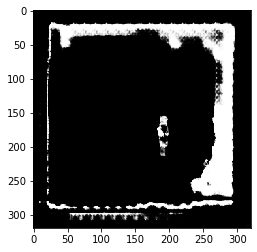

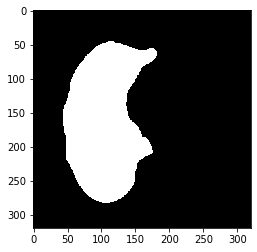

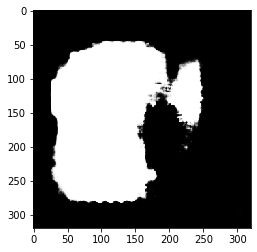

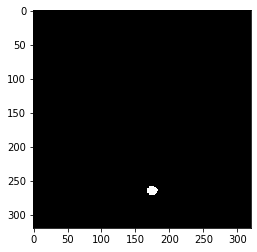

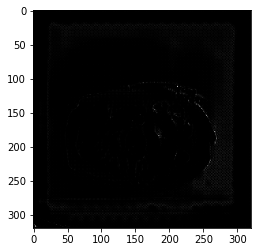

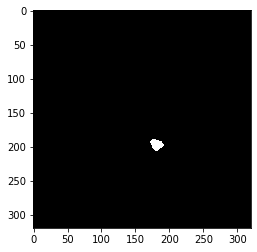

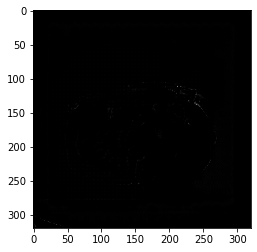

Epoch 10/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.2526 - acc: 0.3882 - binary_crossentropy: 0.2801 - dice_coefficient: 0.7474 - val_loss: 0.4513 - val_acc: 0.1761 - val_binary_crossentropy: 0.4961 - val_dice_coefficient: 0.5487


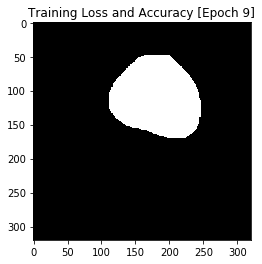

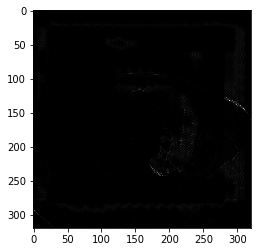

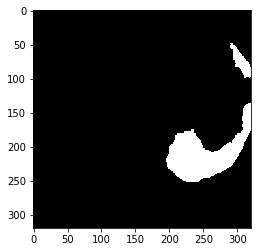

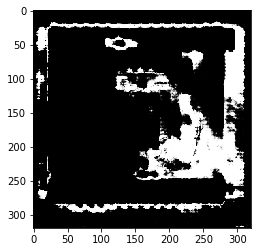

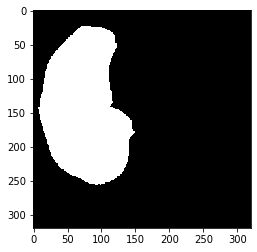

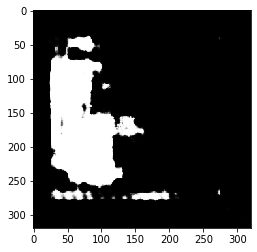

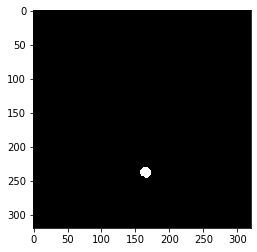

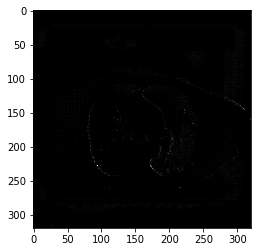

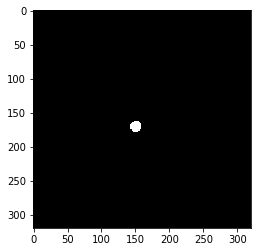

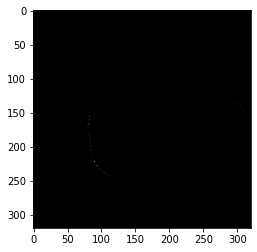

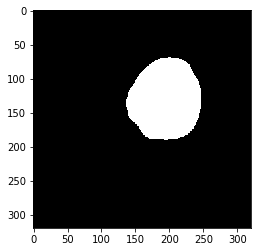

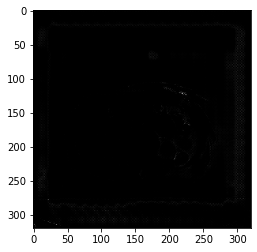

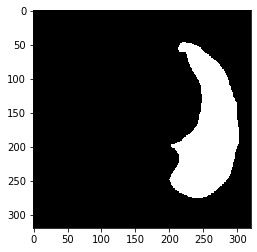

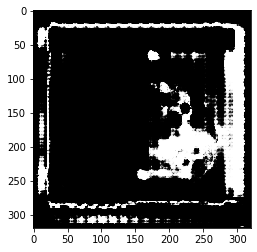

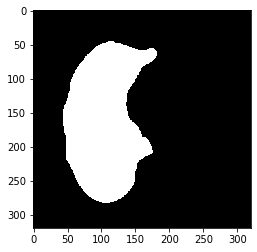

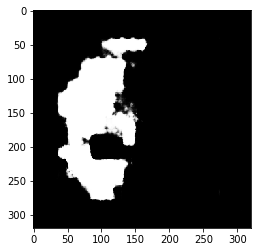

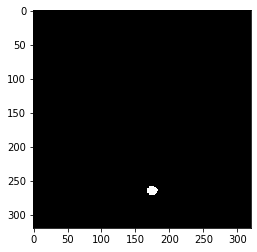

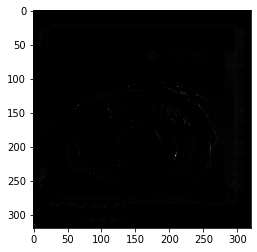

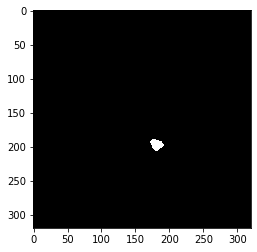

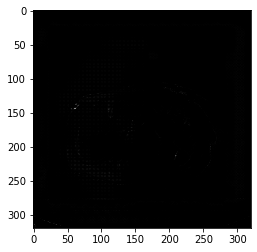

Epoch 11/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.2137 - acc: 0.4466 - binary_crossentropy: 0.2447 - dice_coefficient: 0.7863 - val_loss: 0.3525 - val_acc: 0.2418 - val_binary_crossentropy: 0.3249 - val_dice_coefficient: 0.6475


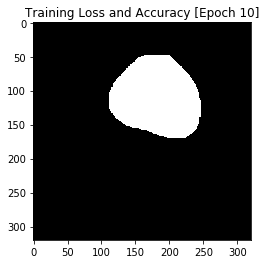

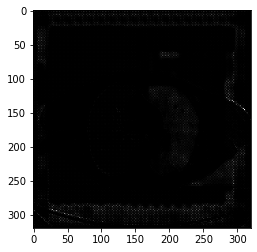

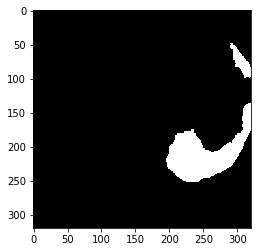

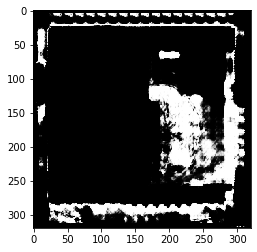

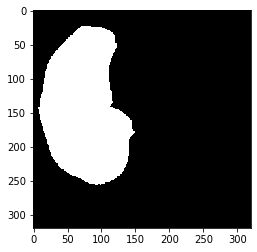

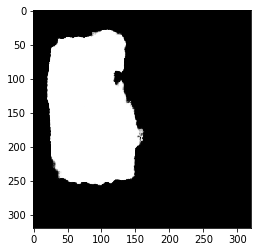

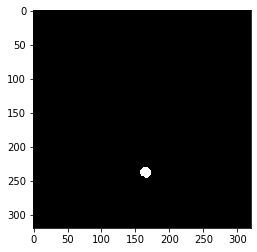

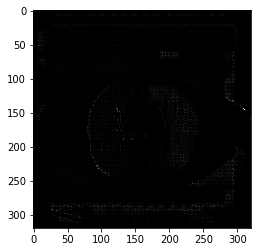

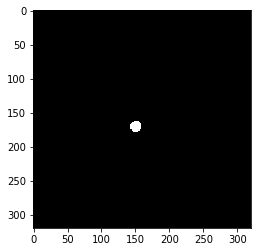

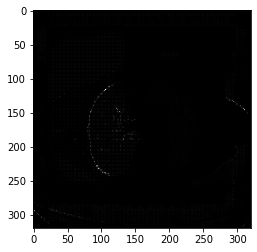

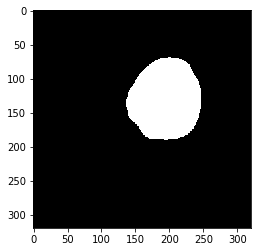

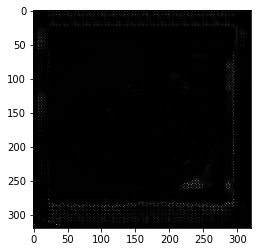

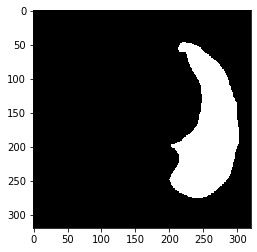

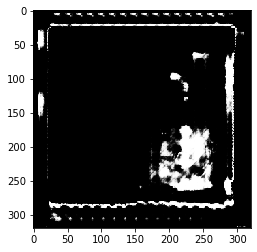

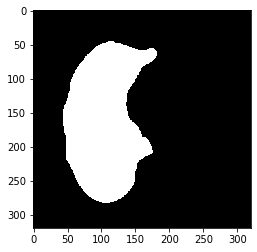

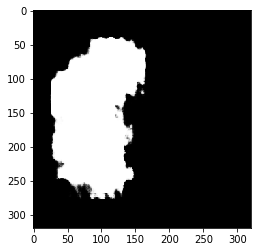

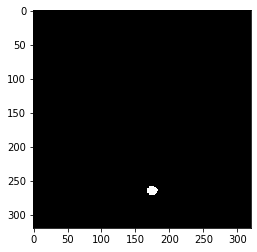

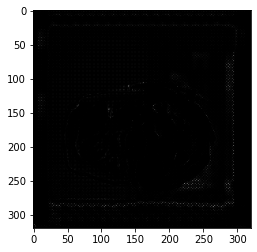

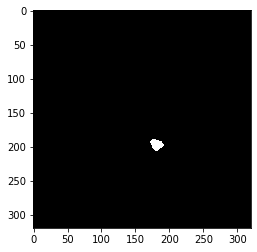

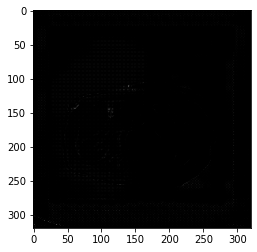

Epoch 12/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.1789 - acc: 0.4917 - binary_crossentropy: 0.2022 - dice_coefficient: 0.8211 - val_loss: 0.4207 - val_acc: 0.4750 - val_binary_crossentropy: 0.4573 - val_dice_coefficient: 0.5793


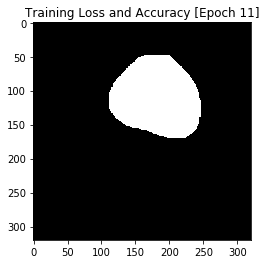

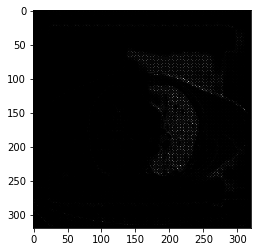

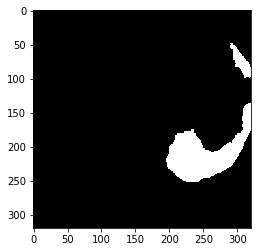

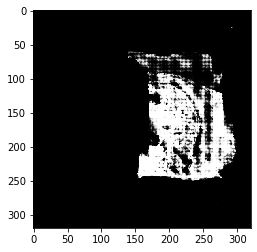

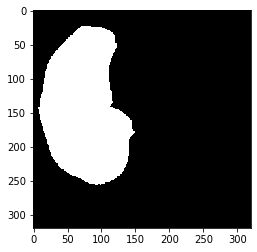

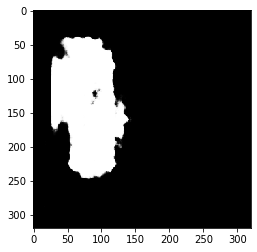

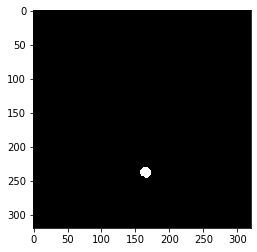

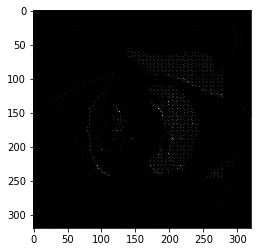

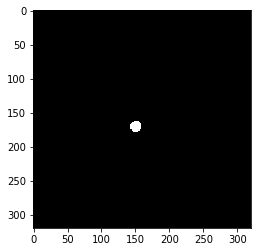

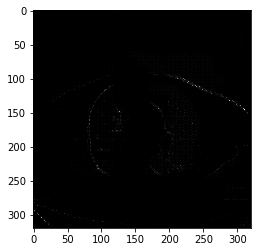

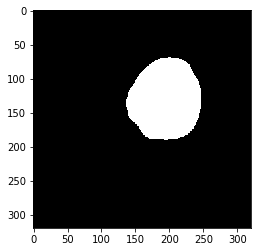

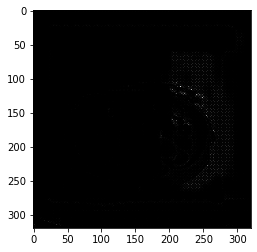

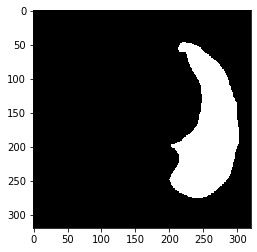

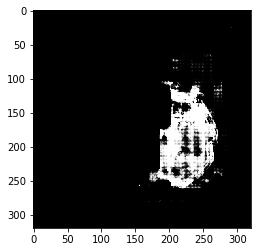

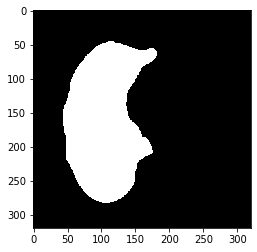

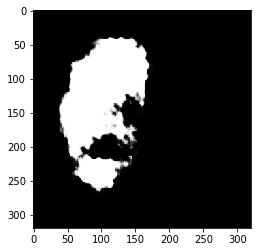

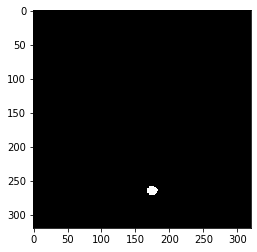

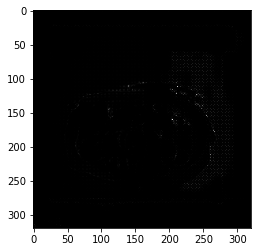

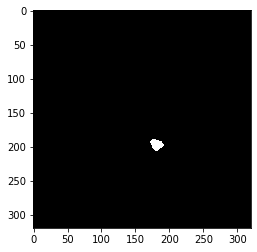

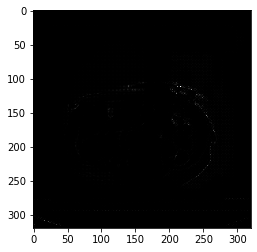

Epoch 13/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.1457 - acc: 0.4960 - binary_crossentropy: 0.1626 - dice_coefficient: 0.8543 - val_loss: 0.4738 - val_acc: 0.4852 - val_binary_crossentropy: 0.5487 - val_dice_coefficient: 0.5262


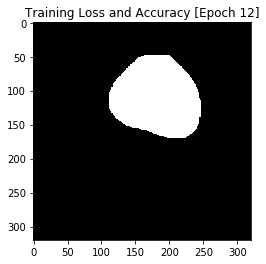

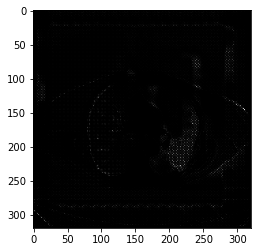

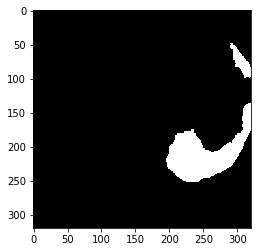

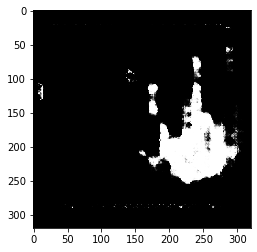

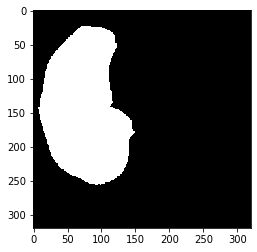

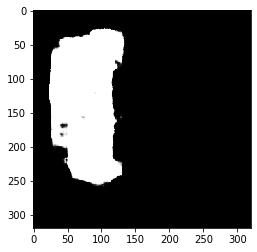

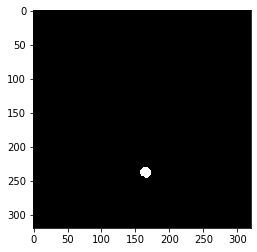

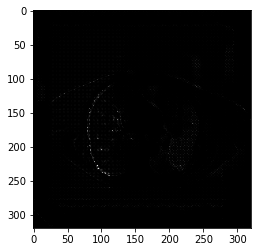

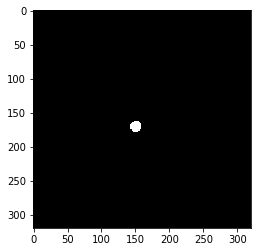

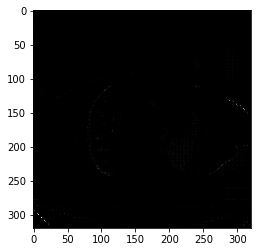

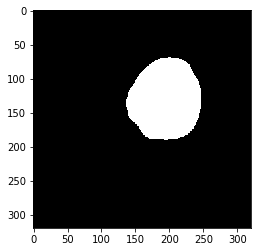

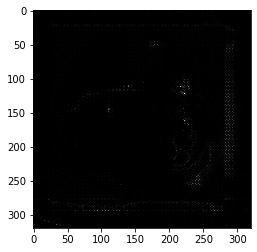

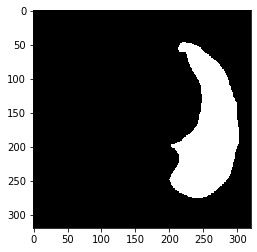

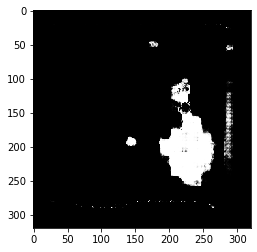

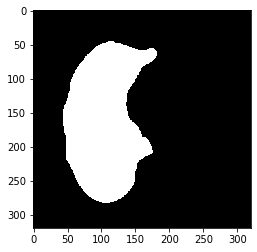

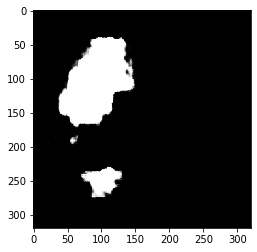

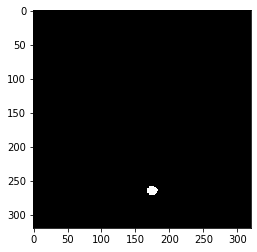

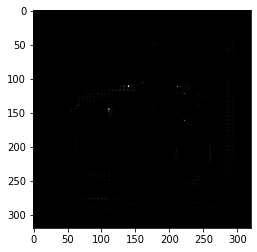

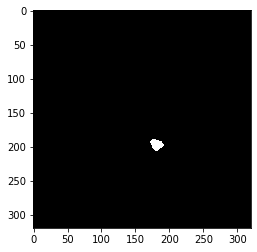

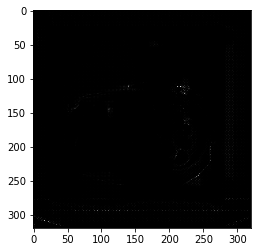

Epoch 14/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.1021 - acc: 0.5326 - binary_crossentropy: 0.1070 - dice_coefficient: 0.8979 - val_loss: 0.2666 - val_acc: 0.5031 - val_binary_crossentropy: 0.2931 - val_dice_coefficient: 0.7334


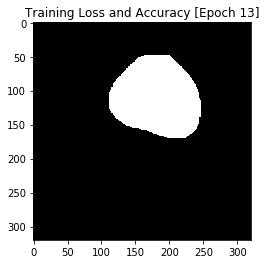

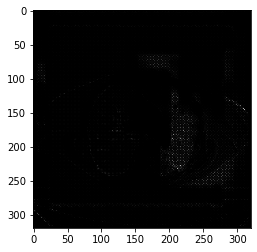

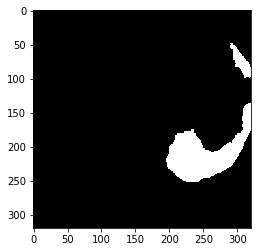

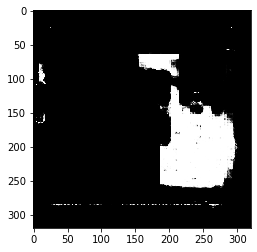

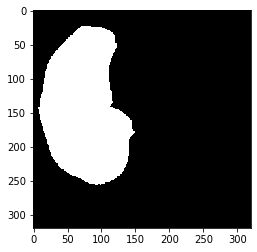

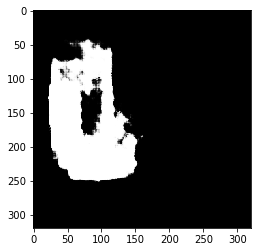

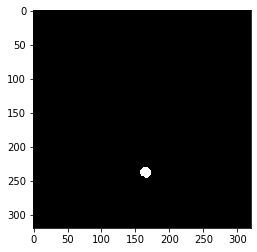

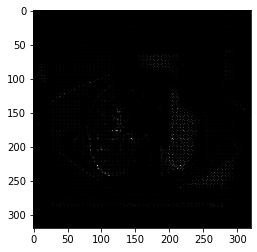

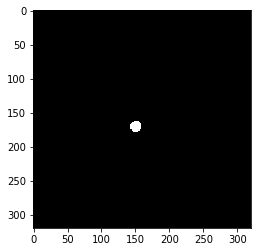

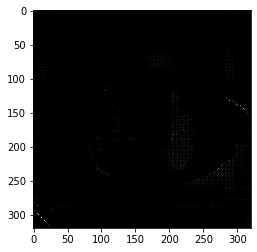

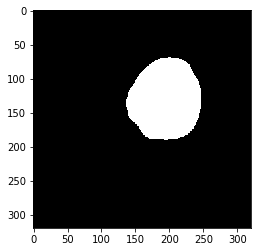

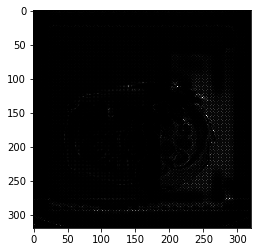

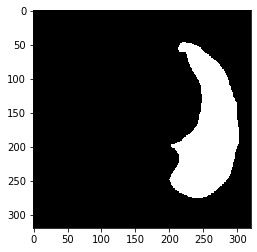

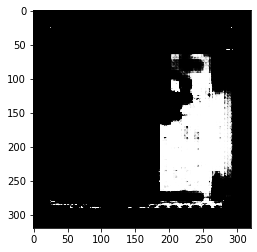

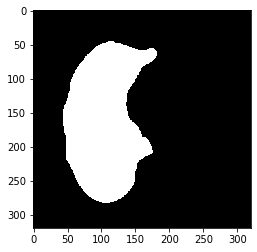

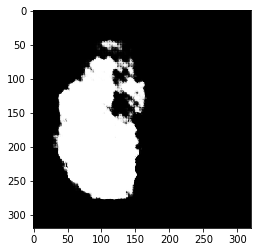

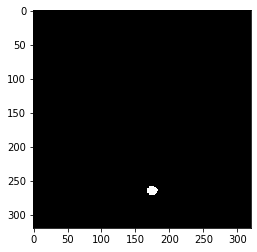

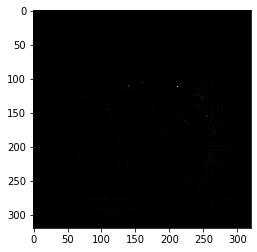

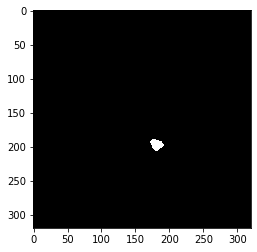

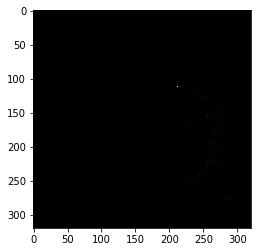

Epoch 15/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.0715 - acc: 0.5680 - binary_crossentropy: 0.0665 - dice_coefficient: 0.9285 - val_loss: 0.4715 - val_acc: 0.4338 - val_binary_crossentropy: 0.6214 - val_dice_coefficient: 0.5285


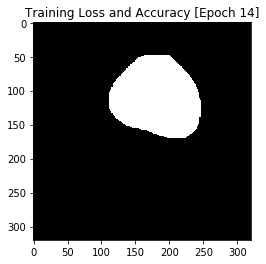

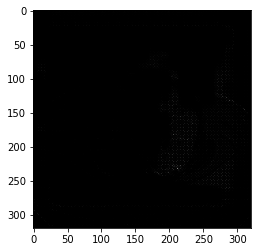

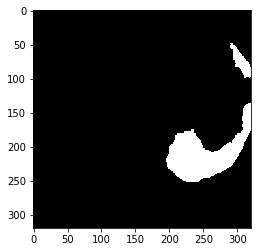

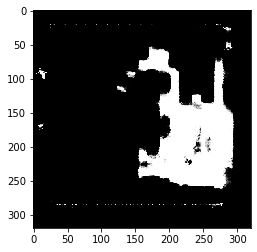

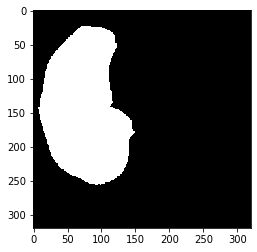

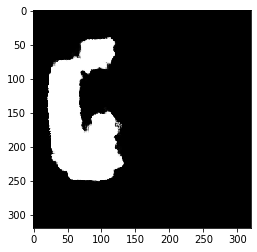

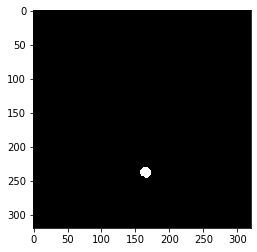

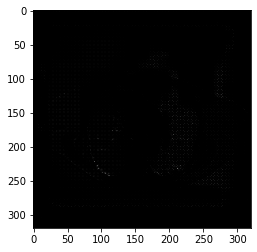

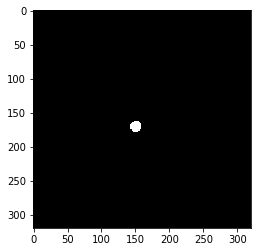

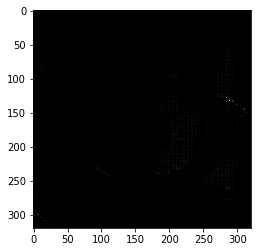

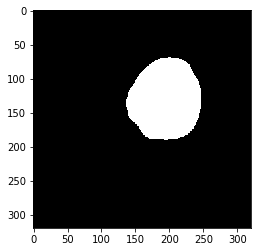

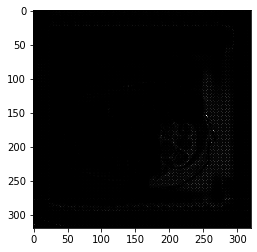

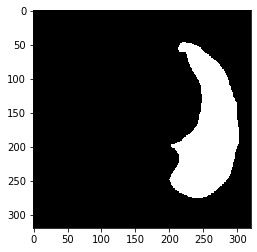

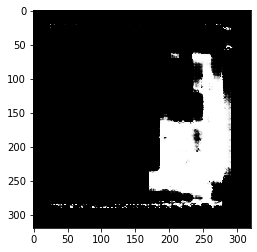

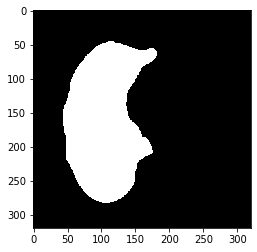

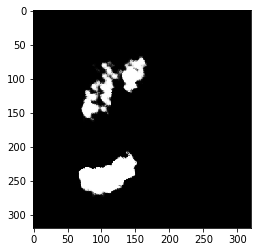

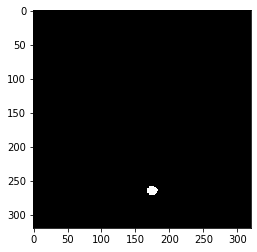

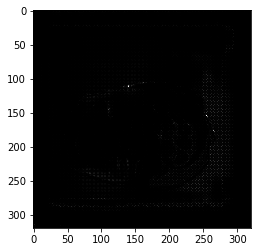

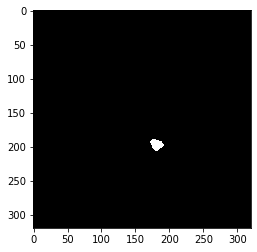

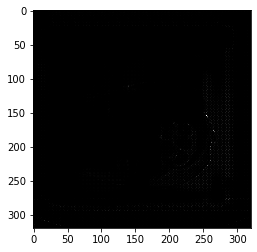

Epoch 16/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.0387 - acc: 0.6389 - binary_crossentropy: 0.0238 - dice_coefficient: 0.9613 - val_loss: 0.1058 - val_acc: 0.4270 - val_binary_crossentropy: 0.0532 - val_dice_coefficient: 0.8942


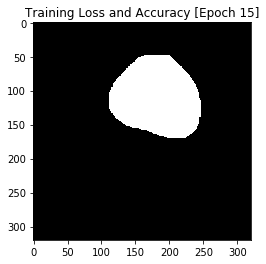

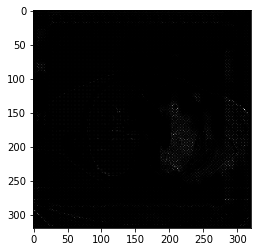

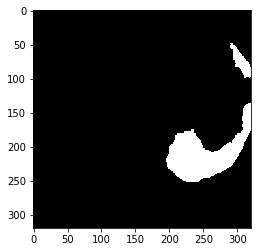

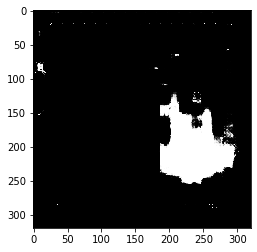

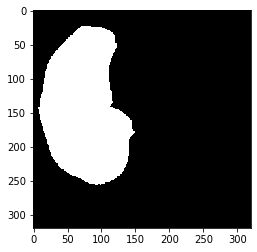

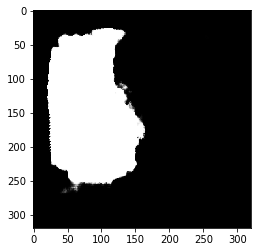

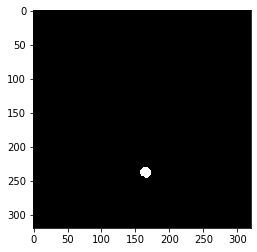

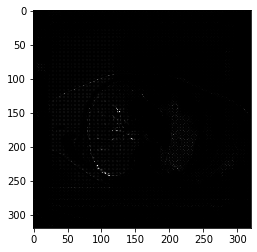

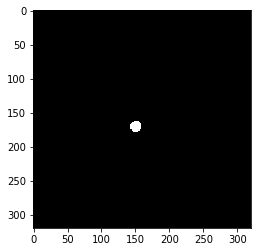

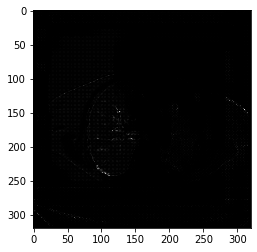

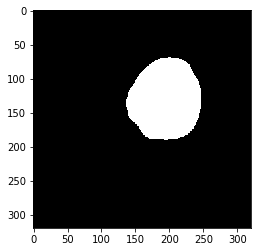

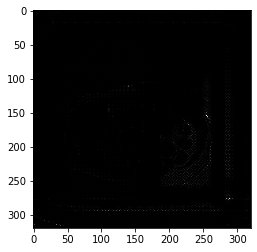

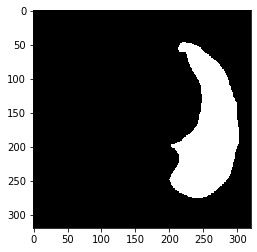

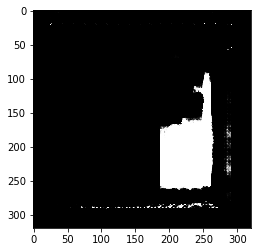

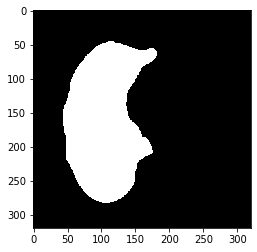

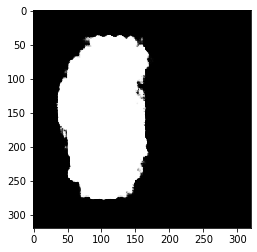

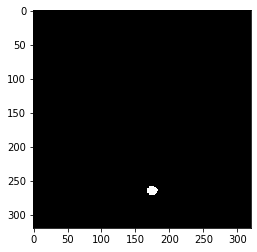

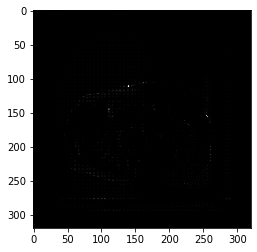

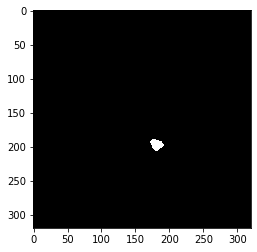

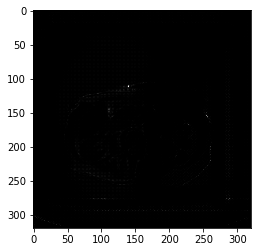

Epoch 17/3000
4557/4557 [==============================] - 199s 44ms/step - loss: 0.0031 - acc: 0.6660 - binary_crossentropy: -0.0242 - dice_coefficient: 0.9969 - val_loss: 0.2213 - val_acc: 0.6459 - val_binary_crossentropy: 0.2407 - val_dice_coefficient: 0.7787


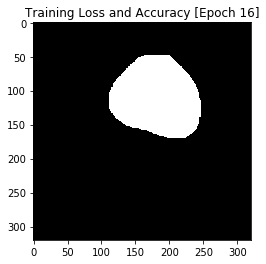

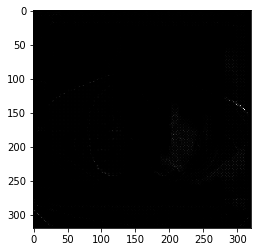

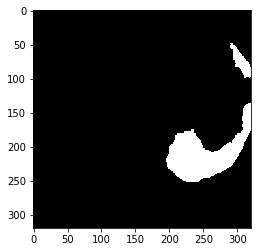

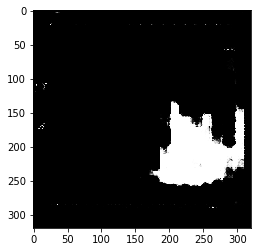

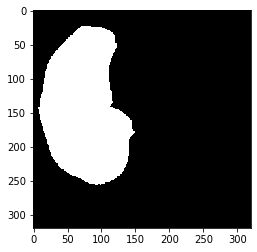

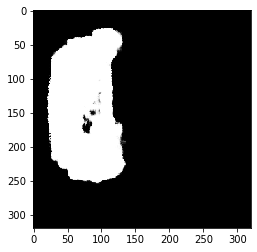

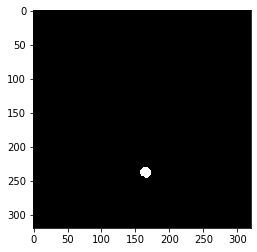

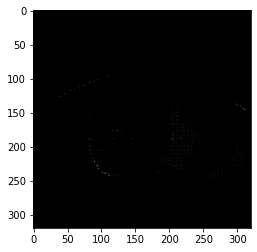

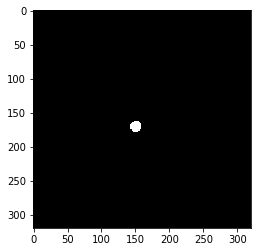

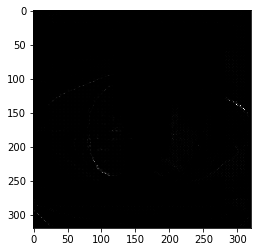

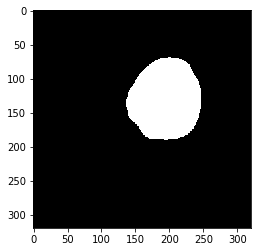

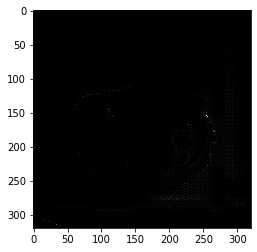

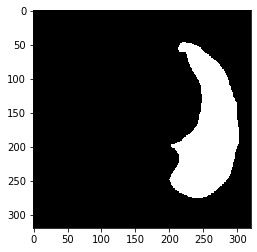

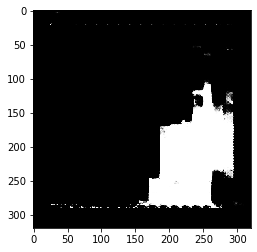

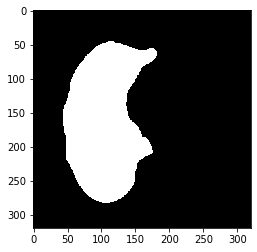

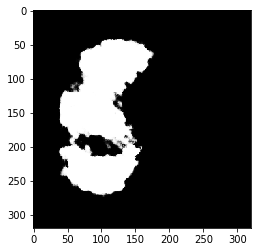

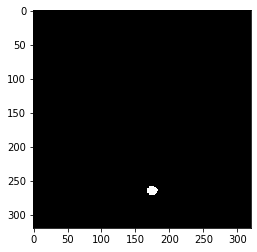

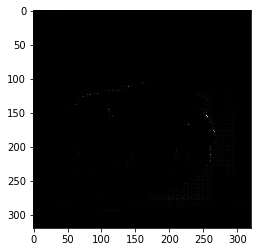

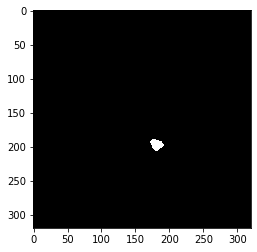

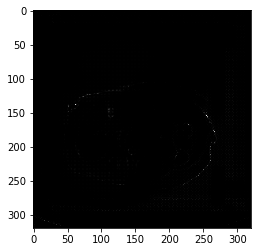

Epoch 18/3000
4557/4557 [==============================] - 199s 44ms/step - loss: -0.0151 - acc: 0.7158 - binary_crossentropy: -0.0557 - dice_coefficient: 1.0151 - val_loss: 0.2721 - val_acc: 0.6908 - val_binary_crossentropy: 0.3509 - val_dice_coefficient: 0.7279


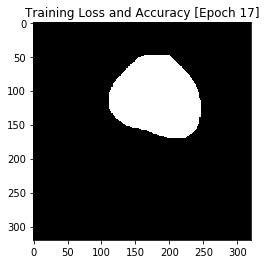

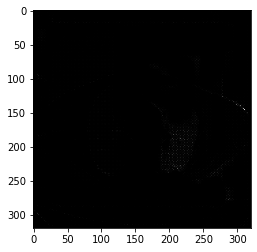

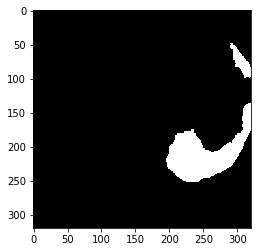

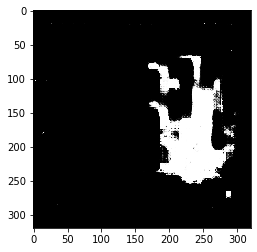

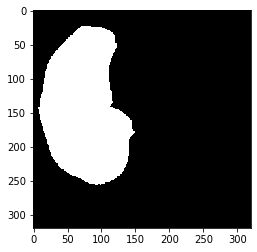

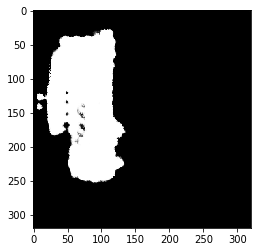

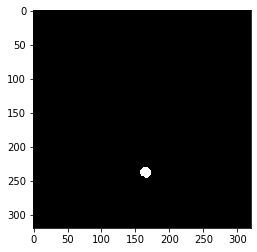

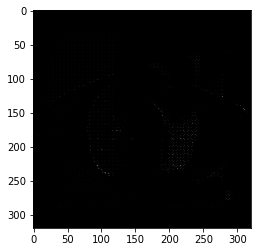

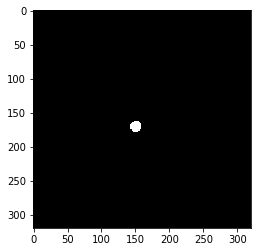

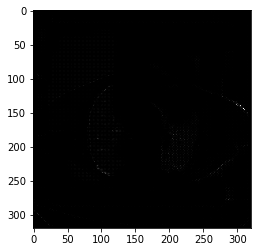

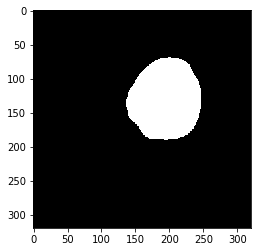

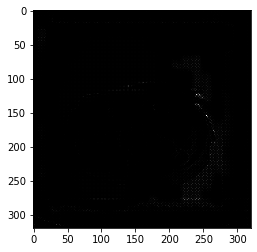

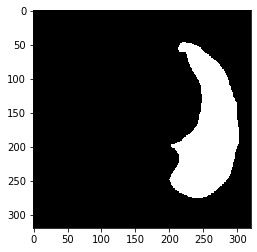

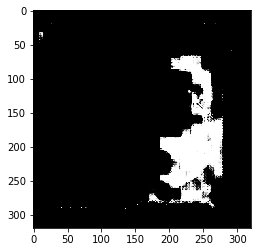

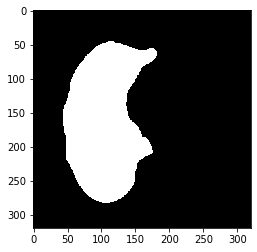

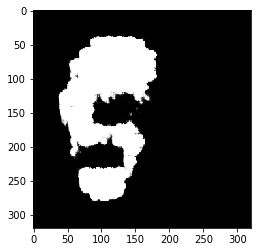

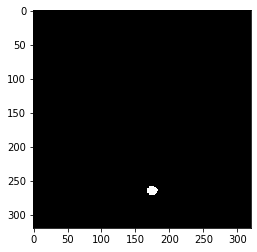

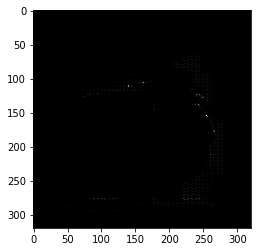

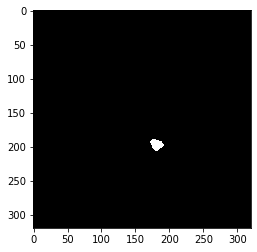

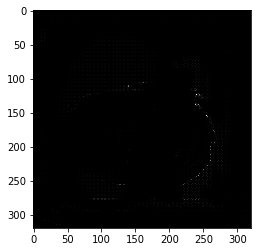

Epoch 19/3000
4557/4557 [==============================] - 199s 44ms/step - loss: -0.0488 - acc: 0.7651 - binary_crossentropy: -0.0959 - dice_coefficient: 1.0488 - val_loss: 0.0708 - val_acc: 0.7239 - val_binary_crossentropy: 0.0238 - val_dice_coefficient: 0.9292


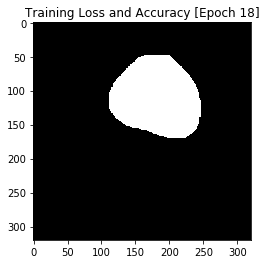

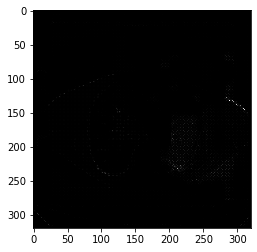

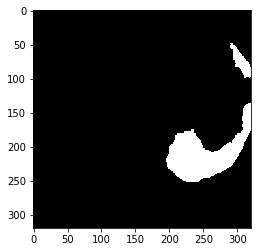

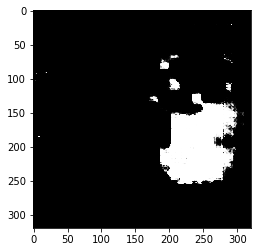

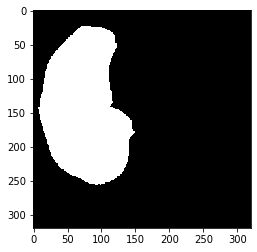

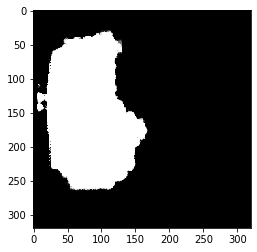

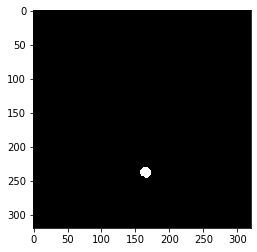

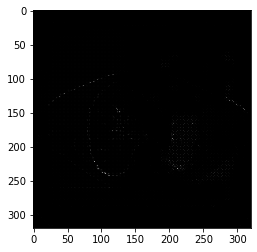

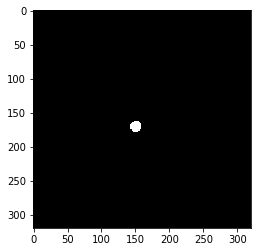

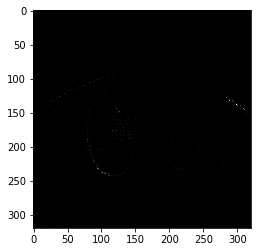

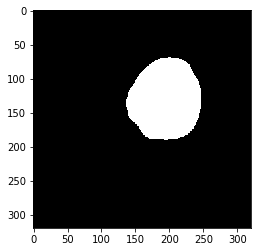

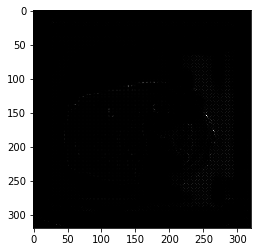

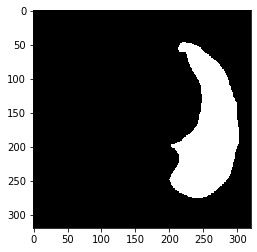

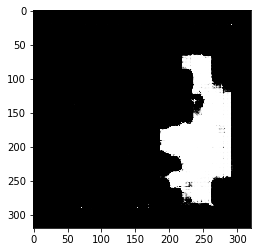

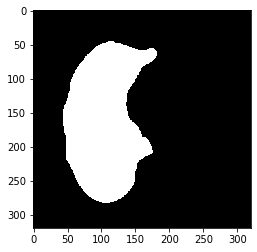

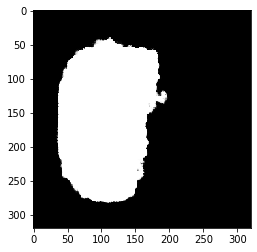

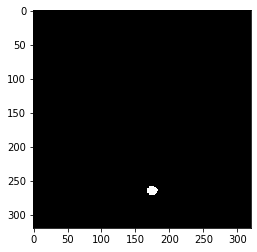

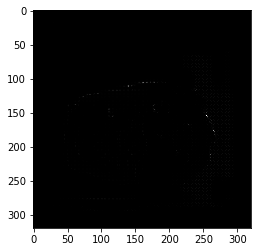

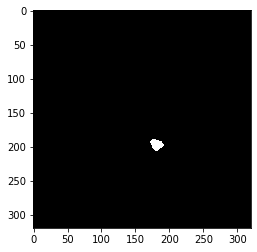

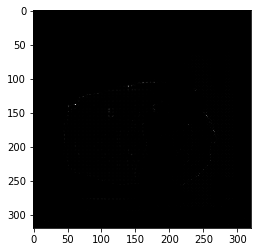

Epoch 20/3000
4557/4557 [==============================] - 199s 44ms/step - loss: -0.0686 - acc: 0.7901 - binary_crossentropy: -0.1165 - dice_coefficient: 1.0686 - val_loss: 0.0149 - val_acc: 0.7809 - val_binary_crossentropy: -0.0202 - val_dice_coefficient: 0.9851


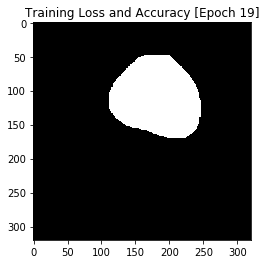

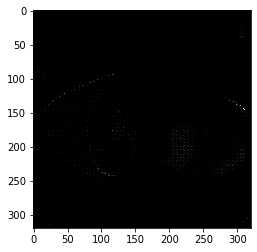

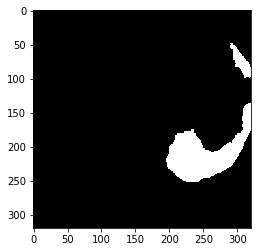

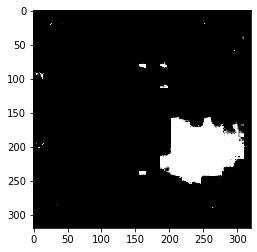

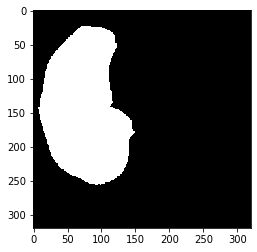

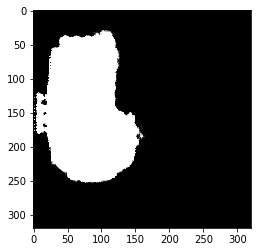

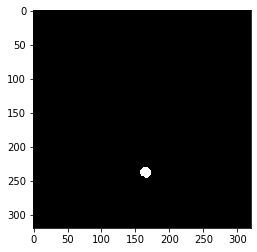

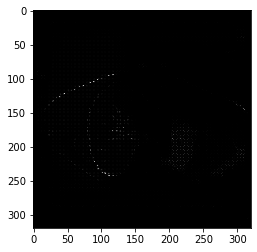

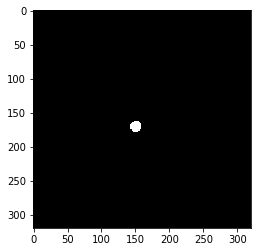

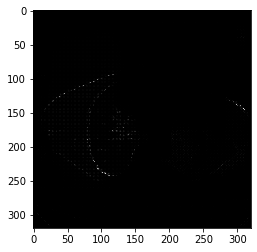

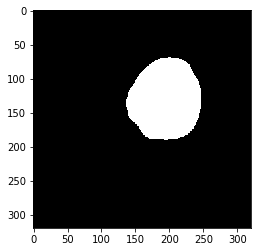

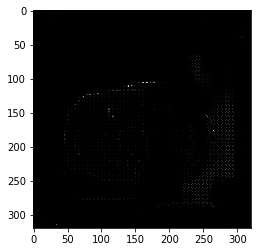

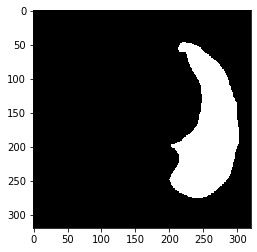

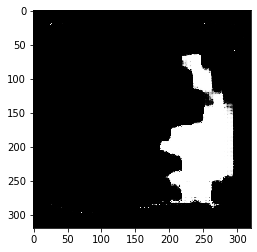

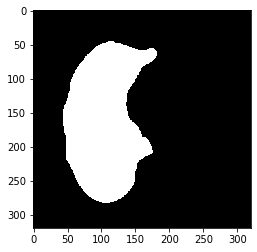

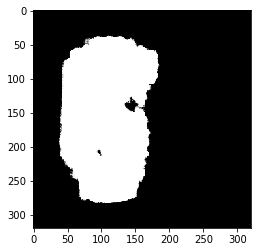

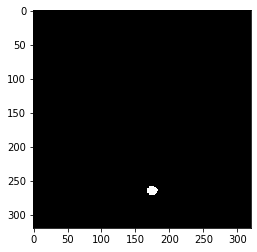

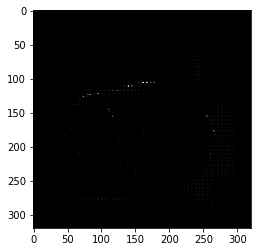

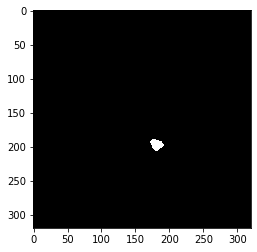

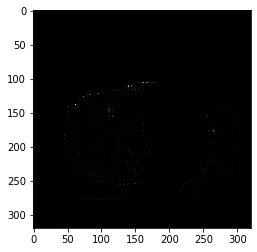

Epoch 21/3000
4557/4557 [==============================] - 199s 44ms/step - loss: -0.0923 - acc: 0.7963 - binary_crossentropy: -0.1378 - dice_coefficient: 1.0923 - val_loss: 0.1283 - val_acc: 0.6756 - val_binary_crossentropy: 0.1070 - val_dice_coefficient: 0.8717


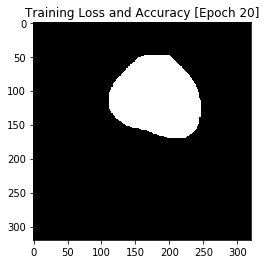

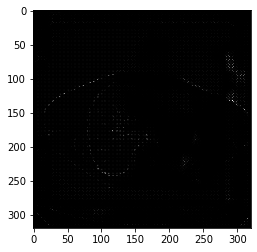

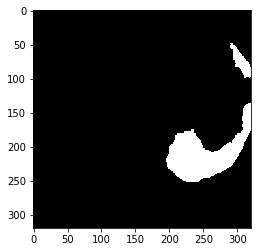

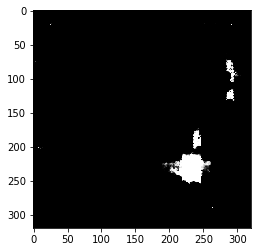

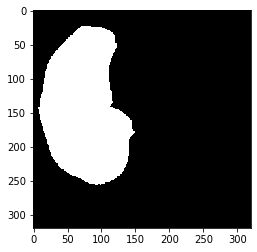

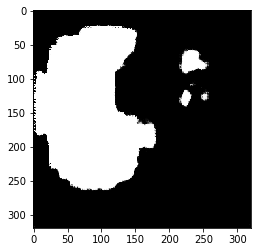

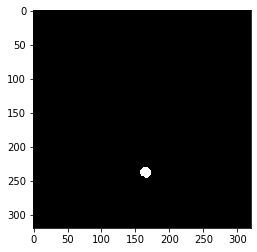

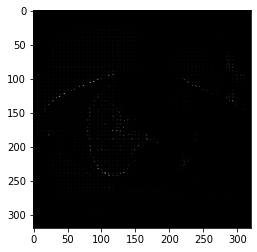

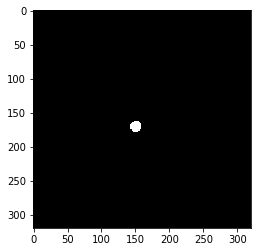

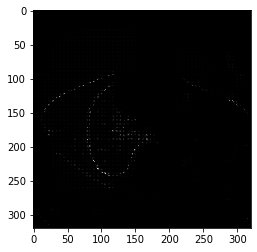

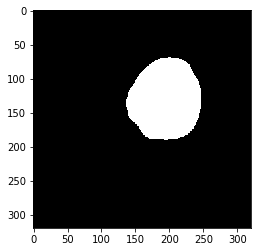

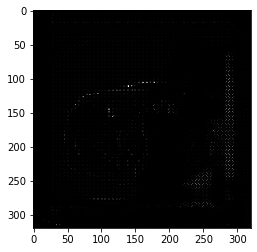

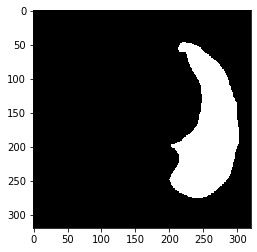

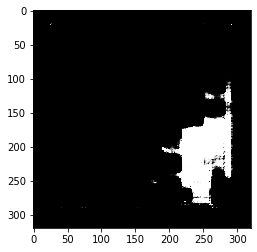

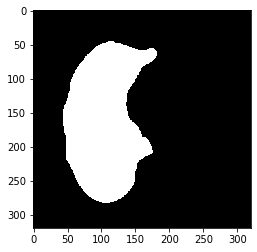

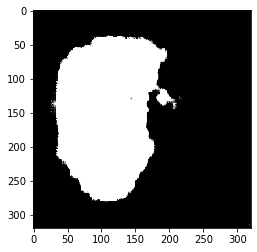

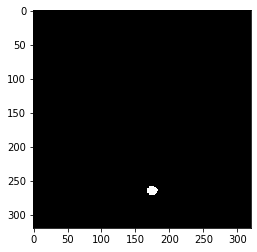

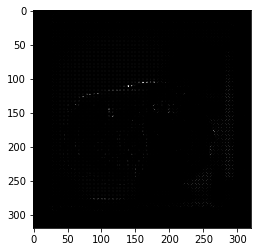

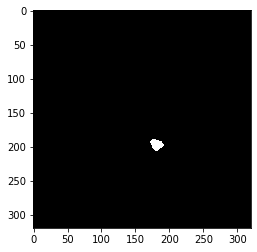

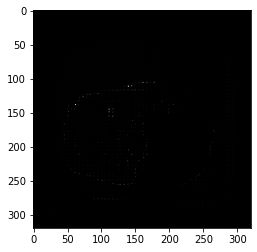

Epoch 22/3000
 336/4557 [=>............................] - ETA: 2:49 - loss: -0.0994 - acc: 0.7915 - binary_crossentropy: -0.1264 - dice_coefficient: 1.0994

In [0]:
train(X_train,y_train, G, bs = 16)

In [0]:
# gen_imgs = models.predict(X_train)

# plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
# plt.pause(0.01)
# plt.imshow(Y[0,:,:,0], cmap = 'gray')
# plt.pause(0.01)